# 0.0. IMPORTS

In [1]:
import sys
import psycopg2
import warnings
import random
import pickle
import requests
import json

import pandas     as pd
import numpy      as np
import seaborn    as sns
import scikitplot as skplt
import xgboost    as xgb
import lightgbm   as lgb


from IPython.core.display    import HTML
from sklearn.model_selection import StratifiedKFold

from matplotlib              import pyplot          as plt
from sklearn                 import preprocessing   as pp
from sklearn                 import model_selection as ms
from sklearn                 import ensemble        as en
from sklearn                 import neighbors       as nh
from sklearn                 import linear_model    as lm

C:\Users\mathe\anaconda3\envs\health_insurance_cross_sell\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# hide warnings
warnings.filterwarnings("ignore")

## 0.1. Aux Functions

In [3]:
# jupyter design
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    %config InlineBackend.figure_format = 'retina'

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 24

#     display(HTML('<style>.container { width:100% !important; }</style>'))
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.options.display.float_format = '{:,.4f}'.format
#     pd.set_option('display.expand_frame_repr', False)
#     pd.set_option('display.max_columns', None)
#     pd.set_option('display.max_rows', None)

    sns.set()
    
jupyter_settings()

# prepare dataset for function precision and recall at k
def concat_order_data( x, y, yhat ):
    
    # copy data
    data = x.copy()
    data['response'] = y.copy()

    # propensity score
    data['score'] = yhat[:, 1].tolist()

    # sorted clients by propensity score
    data = data.sort_values( 'score', ascending=False )
    
    return data

# precision at k
def precision_at_k( data, k=20000 ):

    # reset index
    data = data.reset_index( drop = True )

    # ranking order columns
    data['ranking'] = data.index + 1

    # precision top k
    data['precision_top_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_top_k']

# recall at k
def recall_at_k( data, k=20000 ):

    # reset index
    data = data.reset_index( drop = True )

    # ranking order columns
    data['ranking'] = data.index + 1

    # precision top k
    data['recall_top_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_top_k']

# all at k metrics as dataframe
def at_k_metrics( model_name, x, y, yhat, k=20000 ):
    data = concat_order_data( x, y, yhat )
    
    pr = precision_at_k( data, k )
    re = recall_at_k( data, k )
    
    return pd.DataFrame({"Precision_at_k": "{}".format(np.round(pr,3)),
                         "Recall_at_k": "{}".format(np.round(re,3))}, index=[model_name])


# stratified cross validation
def cross_validation(model_name, model, x, y, k=20000 ):
    
    precision_at_k_list = []
    recall_at_k_list = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, test_index in skf.split(x, y):
        
        x_train_cv = x.iloc[train_index]
        y_train_cv = y.iloc[train_index]
        
        x_test_cv = x.iloc[test_index]
        y_test_cv = y.iloc[test_index]
        
        # model training
        model.fit(x_train_cv, y_train_cv)
        
        # prediction
        pred = model.predict_proba(x_test_cv)
        
        # concat
        data = x_test_cv.copy()
        data['response'] = y_test_cv.copy()
        
        data['score'] = pred[:, 1].tolist()
        
        data = data.sort_values( 'score', ascending=False )
        
        # measuring at k metrics
        precision_at_k_list.append( precision_at_k( data, k ) )
        recall_at_k_list.append(recall_at_k( data, k ) )
        
    
    precision_at_k_mean, precision_at_k_std = np.round( np.mean( precision_at_k_list ), 2 ), np.round( np.std( precision_at_k_list ), 2 )
    recall_at_k_mean, recall_at_k_std = np.round( np.mean( recall_at_k_list ), 2 ), np.round( np.std( recall_at_k_list ), 2 )
   
    
    return pd.DataFrame({"Precision_at_k": "{} +/- {}".format(precision_at_k_mean, precision_at_k_std),
                         "Recall_at_k": "{} +/- {}".format(recall_at_k_mean, recall_at_k_std)}, index=[model_name])

Populating the interactive namespace from numpy and matplotlib


## 0.2. Data collection

### 0.2.1. Train dataset

In [4]:
# connection = psycopg2.connect( user = 'member',
#                                password = 'cdspa',
#                                host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com',
#                                port = '5432',
#                                database = 'comunidadedsdb' )

# cursor = connection.cursor()

# query = """ SELECT *
#             FROM pa004.users
#             LEFT JOIN pa004.insurance on ( users.id = insurance.id )
#             LEFT JOIN pa004.vehicle on ( users.id = vehicle.id ) """

# cursor.execute( query )

# table = cursor.fetchall()

# outputquery = 'copy ({0}) to stdout with csv header'.format( query )

# with open( 'dataset.csv', 'w' ) as f:
#     cursor.copy_expert( outputquery, f )

# cursor.close()
# connection.close()

In [5]:
df_raw = pd.read_csv( 'data/train_dataset.csv' )
df_raw = df_raw.drop( df_raw.columns[[ 5, 10 ]], axis=1 )

### 0.2.2. Test dataset ( live production environment )

In [6]:
df_test = pd.read_csv( 'data/test.csv' ) 

In [7]:
# test dataset check
df_test.shape

(127037, 11)

# 1.0. DATA DESCRIPTION

In [8]:
df1 = df_raw.copy()

## 1.1. Columns Description

In [9]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage', 'response',
       'driving_license', 'vehicle_age', 'vehicle_damage'],
      dtype='object')

- **id**: Unique ID for the customer

- **gender**: Gender of the customer

- **age**: Age of the customer

- **driving_license**: 0 = Customer does not have DL, 1 = Customer already has DL

- **region_code**: Unique code for the region of the customer

- **previously_insured**:	1 = Customer already has Vehicle Insurance, 0 = Customer doesn't have Vehicle Insurance

- **vehicle_age**: Age of the Vehicle

- **vehicle_damage**: 1 = Customer got his/her vehicle damaged in the past, 0 = Customer didn't get his/her vehicle damaged in the past

- **annual_premium**:	The amount customer needs to pay as premium in the year

- **policy_sales_channel**: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc

- **vintage**: Number of Days Customer has been associated with the company

- **response**: 1 = Customer is interested, 0 = Customer is not interested

### 1.1.1. Rename Columns

No need, columns are already on snakecase.

## 1.2. Data Dimensions

In [10]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 381109
Number of columns: 12


## 1.3. Data types

In [11]:
df1.dtypes

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
driving_license          int64
vehicle_age             object
vehicle_damage          object
dtype: object

## 1.4. NA check

In [12]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
response                0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

### 1.4.1. NA fullfill

There's no NA data.

## 1.5. Descriptive Statistics

In [13]:
df_num = df1[['age','annual_premium','vintage']]

df_cat = df1[['gender',
              'region_code',
              'policy_sales_channel',
              'previously_insured',
              'response',
              'driving_license',
              'vehicle_age',
              'vehicle_damage']]

### 1.5.1. Numerical attributes

In [14]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# central tendency - mean, median
ct1 = pd.DataFrame( df_num.apply( lambda x: np.mean( x ) ) ).T
ct2 = pd.DataFrame( df_num.apply( lambda x: np.median( x ) ) ).T

# dispersion metrics - min, max, range, std, skewness, kurtosis
dm1 = pd.DataFrame( df_num.apply( lambda x: np.min( x ) ) ).T
dm2 = pd.DataFrame( df_num.apply( lambda x: np.max( x ) ) ).T
dm3 = pd.DataFrame( df_num.apply( lambda x: np.max( x ) - np.min( x ) ) ).T
dm4 = pd.DataFrame( df_num.apply( lambda x: np.std( x ) ) ).T
dm5 = pd.DataFrame( df_num.apply( lambda x: x.skew() ) ).T
dm6 = pd.DataFrame( df_num.apply( lambda x: x.kurtosis() ) ).T

# concat
df_description = pd.concat( [ dm1, dm2, dm3, ct1, ct2, dm4, dm5, dm6 ] ).T
df_description.columns = ( 'min', 'max', 'range', 'mean', 'median', 'std', 'skewness', 'kurtosis' )
df_description

,min,max,range,mean,median,std,skewness,kurtosis
age,20.000,85.000,65.000,38.823,36.000,15.512,0.673,-0.566
annual_premium,2630.000,540165.000,537535.000,30564.390,31669.000,17213.132,1.766,34.005
vintage,10.000,299.000,289.000,154.347,154.000,83.671,0.003,-1.201


### 1.5.2. Categorical attributes

In [15]:
df_cat.apply( lambda x: x.unique().shape[0] )

gender                    2
region_code              53
policy_sales_channel    155
previously_insured        2
response                  2
driving_license           2
vehicle_age               3
vehicle_damage            2
dtype: int64

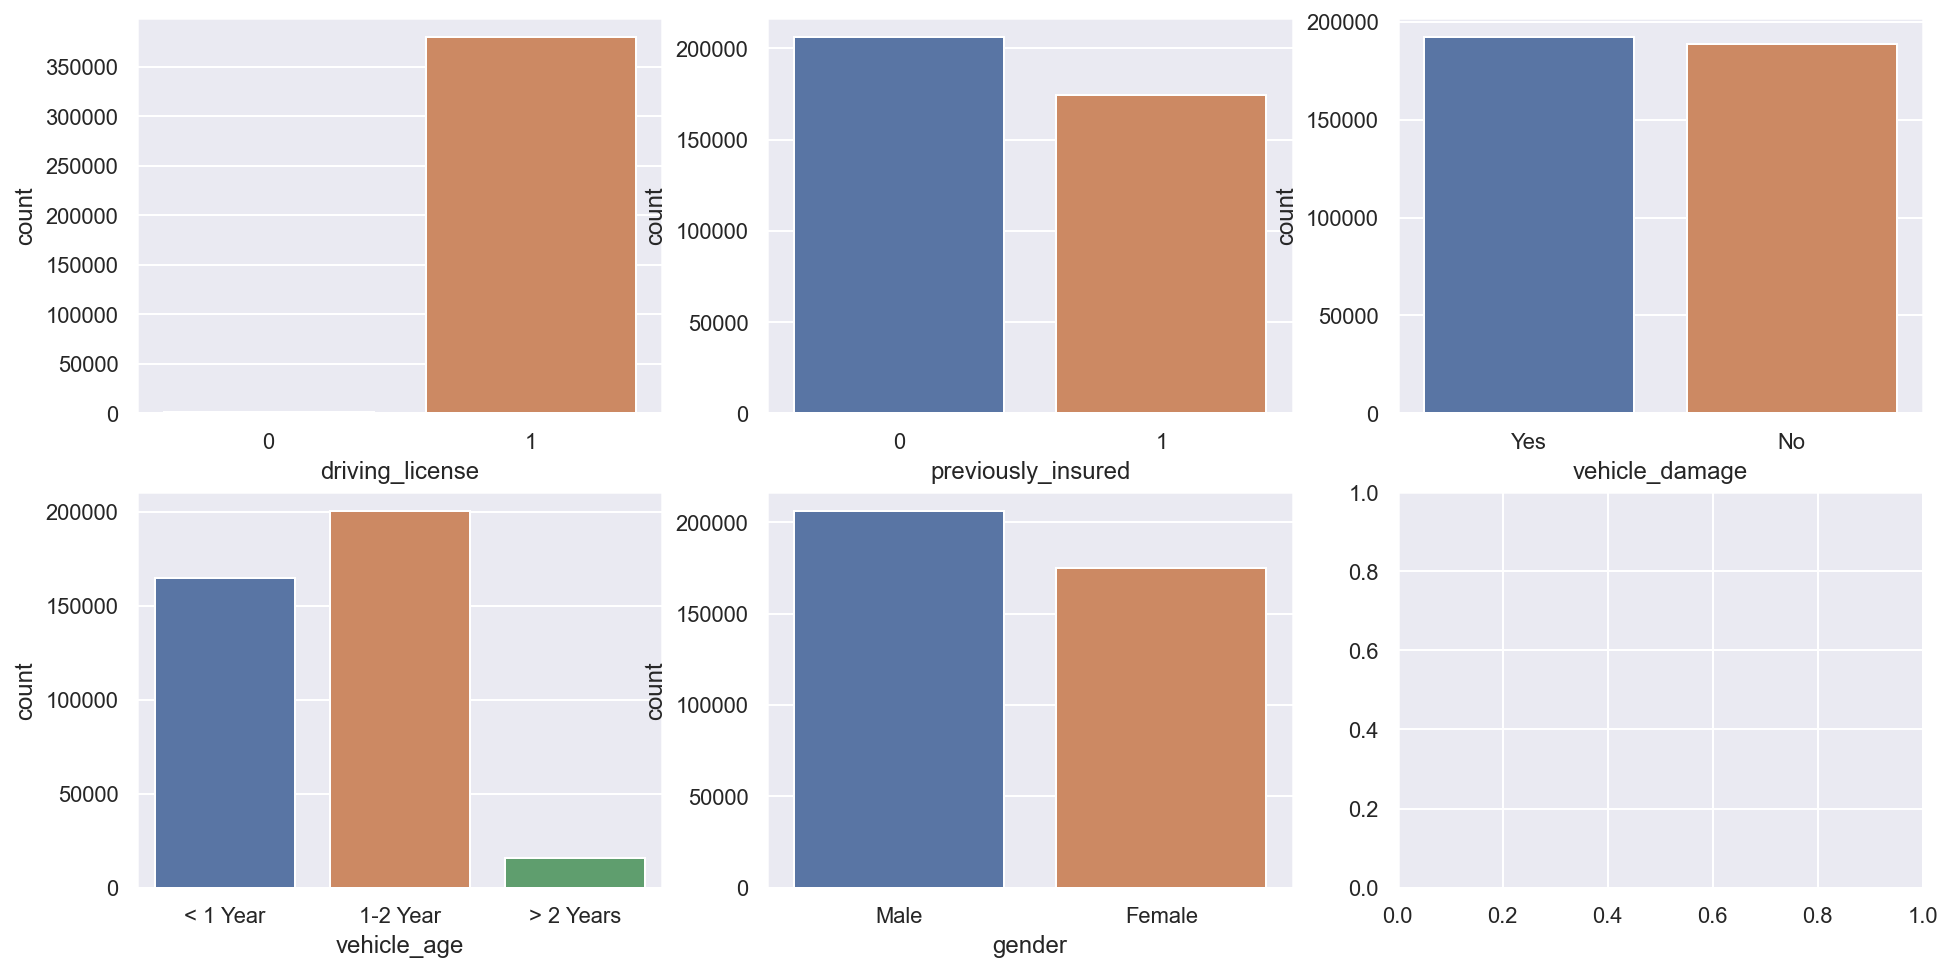

In [16]:
fig, axs = plt.subplots(ncols = 3, nrows = 2,  figsize = (16,8))

sns.countplot(x ='driving_license', data= df_cat, ax=axs[0][0]);
sns.countplot(x = 'previously_insured', data=df_cat, ax=axs[0][1]);
sns.countplot(x = 'vehicle_damage', data=df_cat, ax=axs[0][2]);

sns.countplot(x = 'vehicle_age', data=df_cat,ax=axs[1][0]);
sns.countplot(x = 'gender', data=df_cat,ax=axs[1][1]);

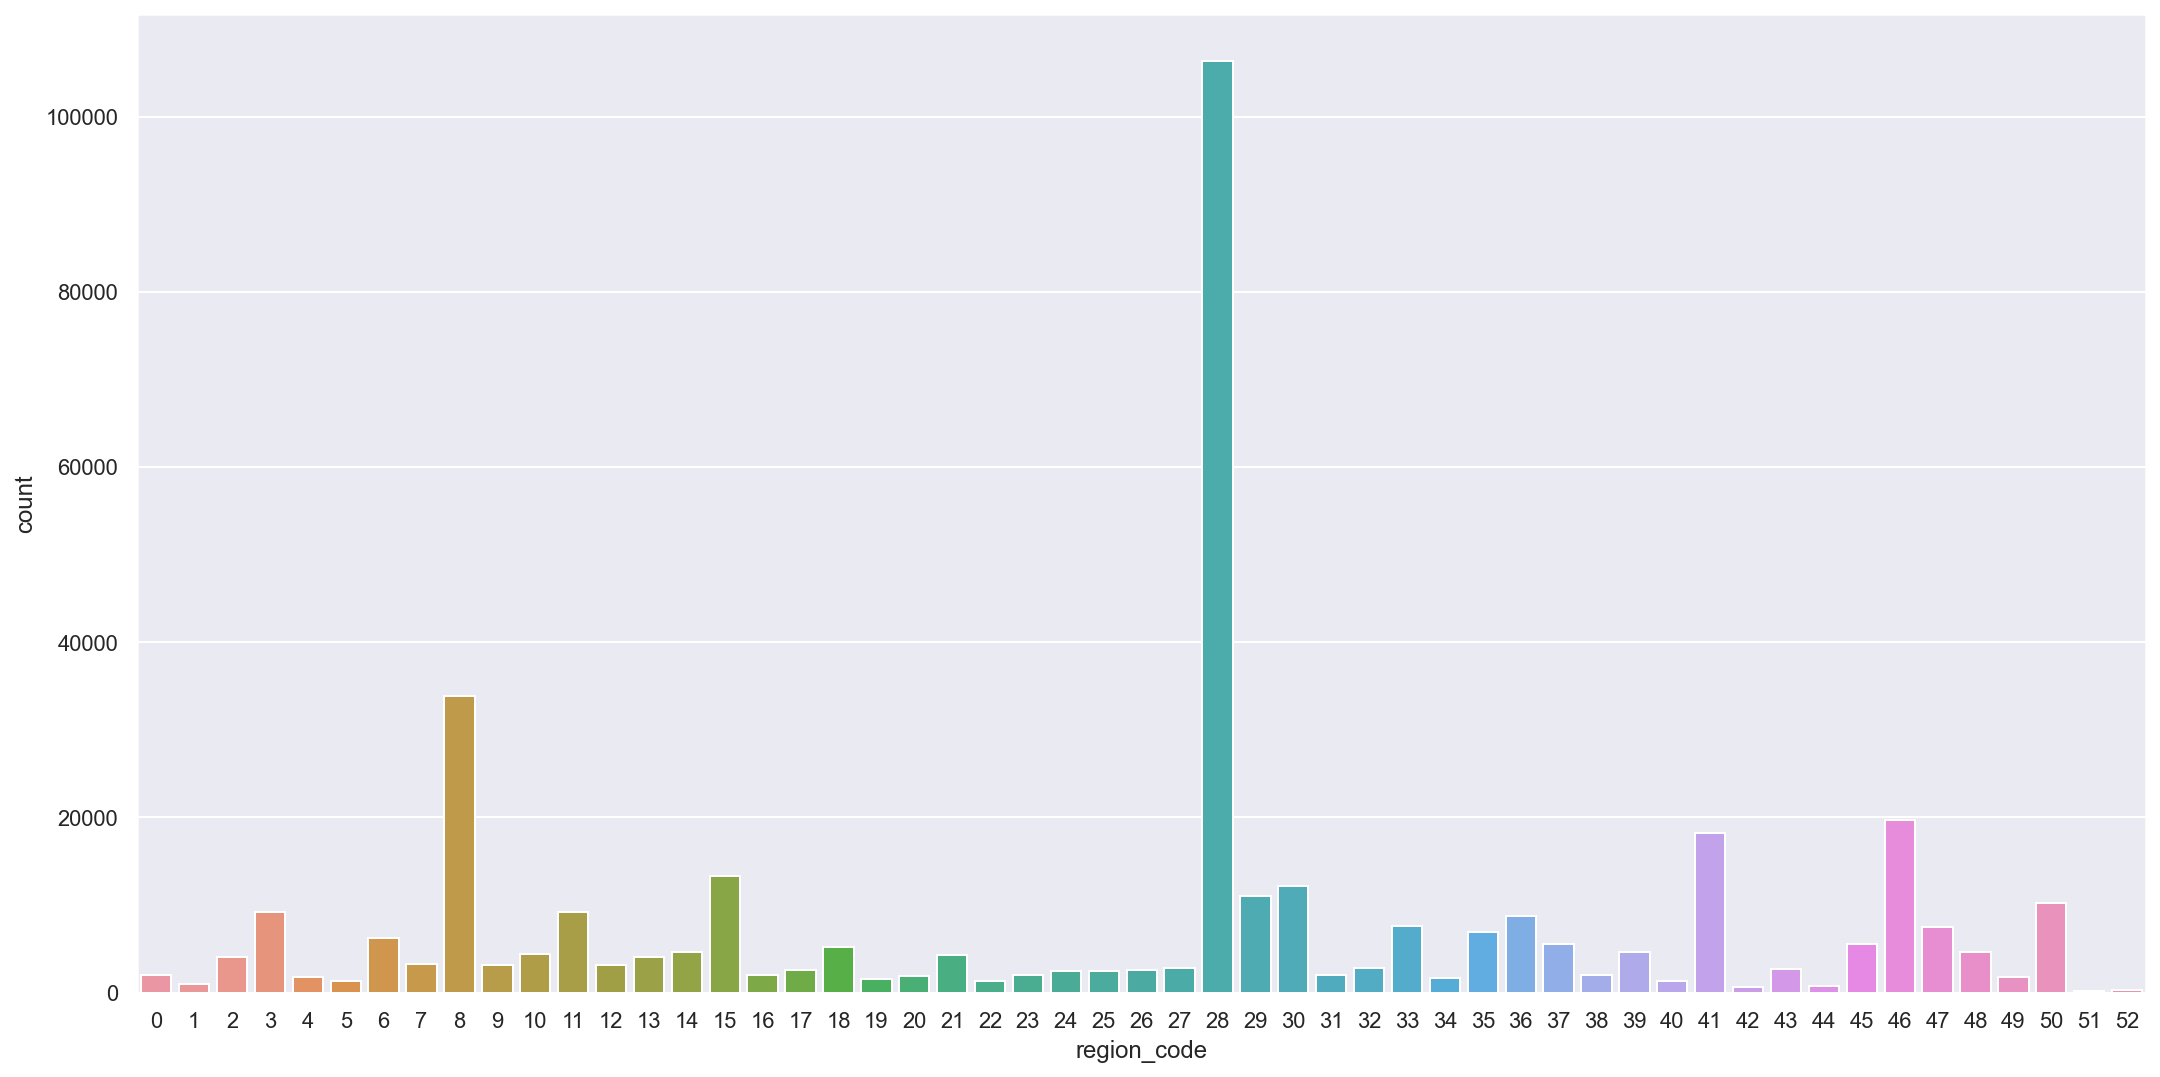

In [17]:
plt.subplots(figsize = (18,9))
sns.countplot( x='region_code', data=df_cat );

<AxesSubplot:xlabel='policy_sales_channel', ylabel='index'>

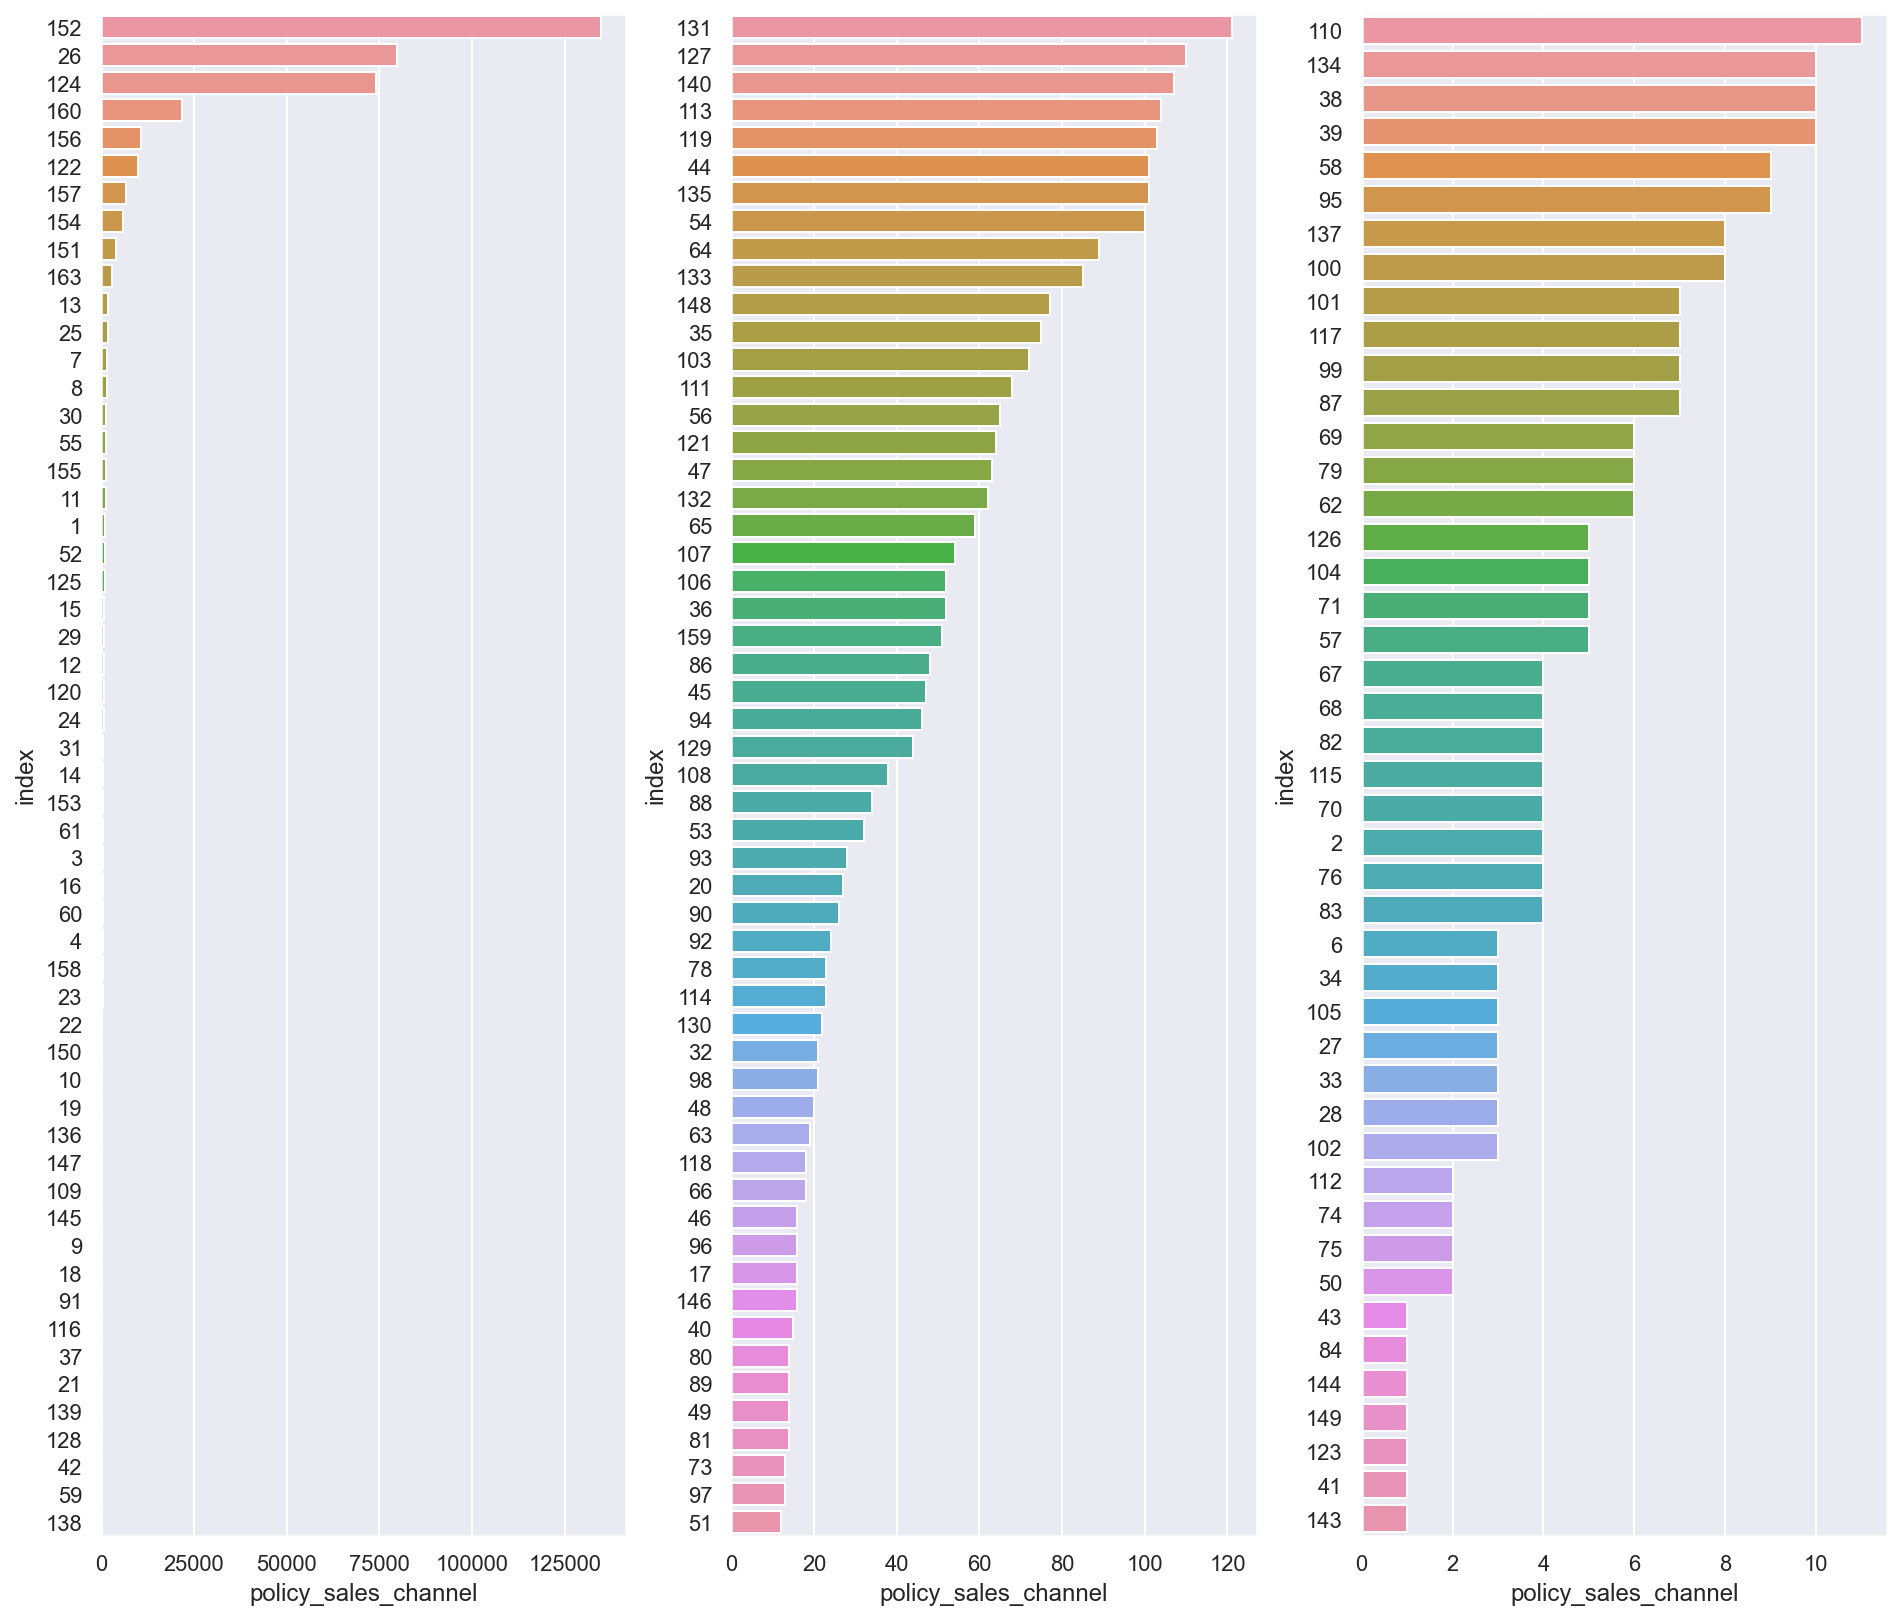

In [18]:
df_policy_1 = df1['policy_sales_channel'].value_counts().iloc[0:55]
df_policy_1 = df_policy_1.reset_index()
df_policy_2 = df1['policy_sales_channel'].value_counts().iloc[55:110]
df_policy_2 = df_policy_2.reset_index()
df_policy_3 = df1['policy_sales_channel'].value_counts().iloc[110:156]
df_policy_3 = df_policy_3.reset_index()

fig, axs = plt.subplots(ncols= 3, figsize = (16,14))
sns.barplot(y = 'index', x='policy_sales_channel', data=df_policy_1, ax=axs[0],orient = 'h',order = df_policy_1['index'])
sns.barplot(y = 'index', x='policy_sales_channel', data=df_policy_2, ax=axs[1],orient = 'h',order = df_policy_2['index'])
sns.barplot(y = 'index', x='policy_sales_channel', data=df_policy_3, ax=axs[2],orient = 'h',order = df_policy_3['index'])

### 1.5.3. Target Variable

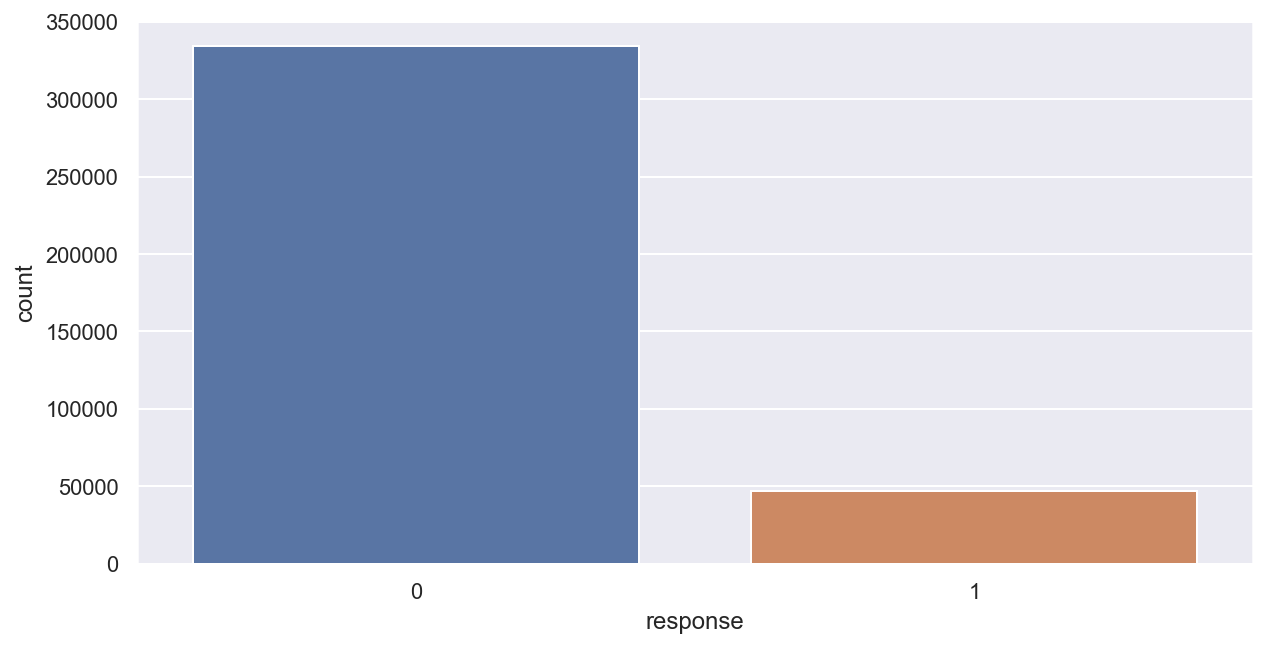

In [19]:
sns.countplot(x = 'response', data=df_cat );

In [20]:
interested = df1[['id','response']].groupby('response').count().reset_index()
interested

,response,id
0,0,334399
1,1,46710


In [21]:
interested_percentage = interested['id'][1] / ( interested['id'][0] + interested['id'][1] )
print( ' Only {:.2%} of the base have interest in vehicle insurance'.format( interested_percentage ) )

 Only 12.26% of the base have interest in vehicle insurance


# 2.0. FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

In [23]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'below_1_year' if x == '< 1 Year' else 
                                                         'between_1_2_years' if x == '1-2 Year' else 'over_2_years' )

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# 3.0. DATA FILTERING

In [24]:
df3 = df2.copy()

No need to do any filtering due to business vision.

# 4.0. EXPLORATORY DATA ANALYSIS

In [25]:
df4 = df3.copy()

## 4.1. Univarieted analysis

### 4.1.1. Numerical Attributes

#### age

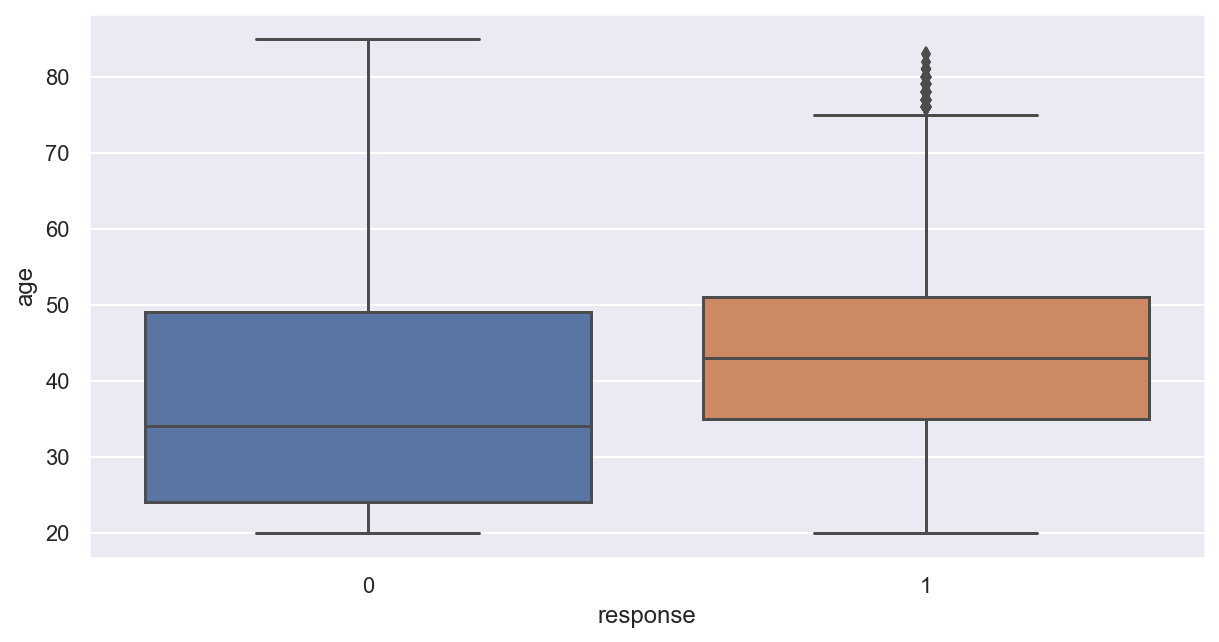

In [26]:
sns.boxplot( x = 'response', y = 'age', data=df4 );

**Not interested ( response = 0 )**

**Interested ( response = 1 )**

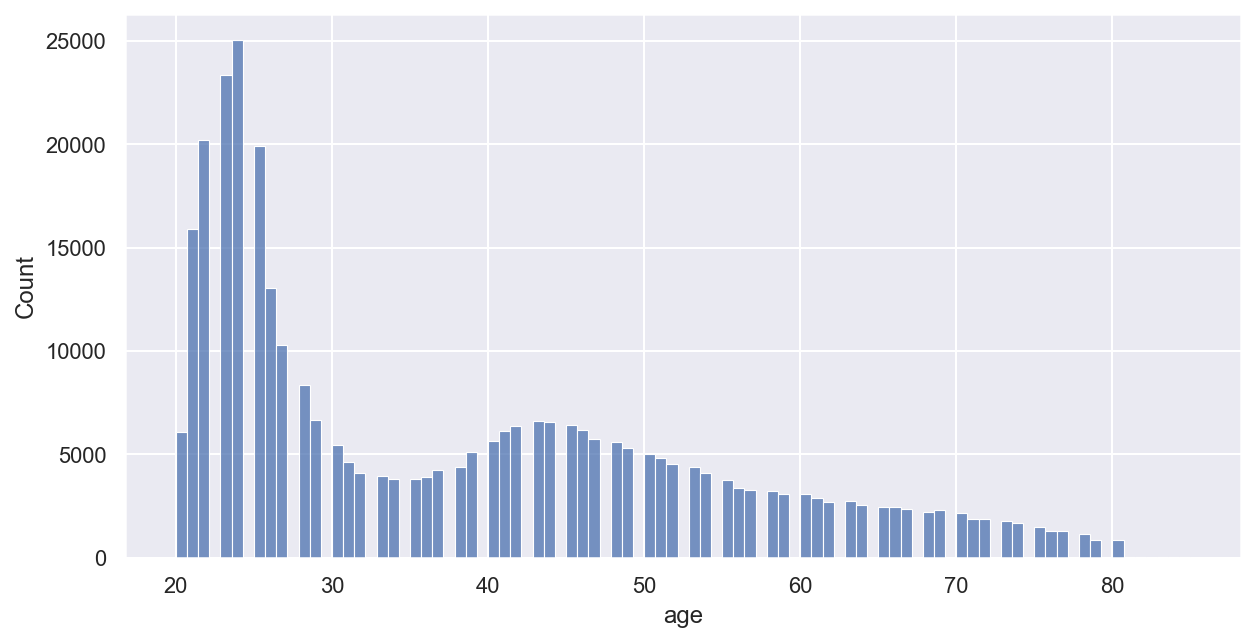

In [27]:
aux0 = df4.loc[ df4['response'] == 0, 'age' ]
sns.histplot( aux0 );

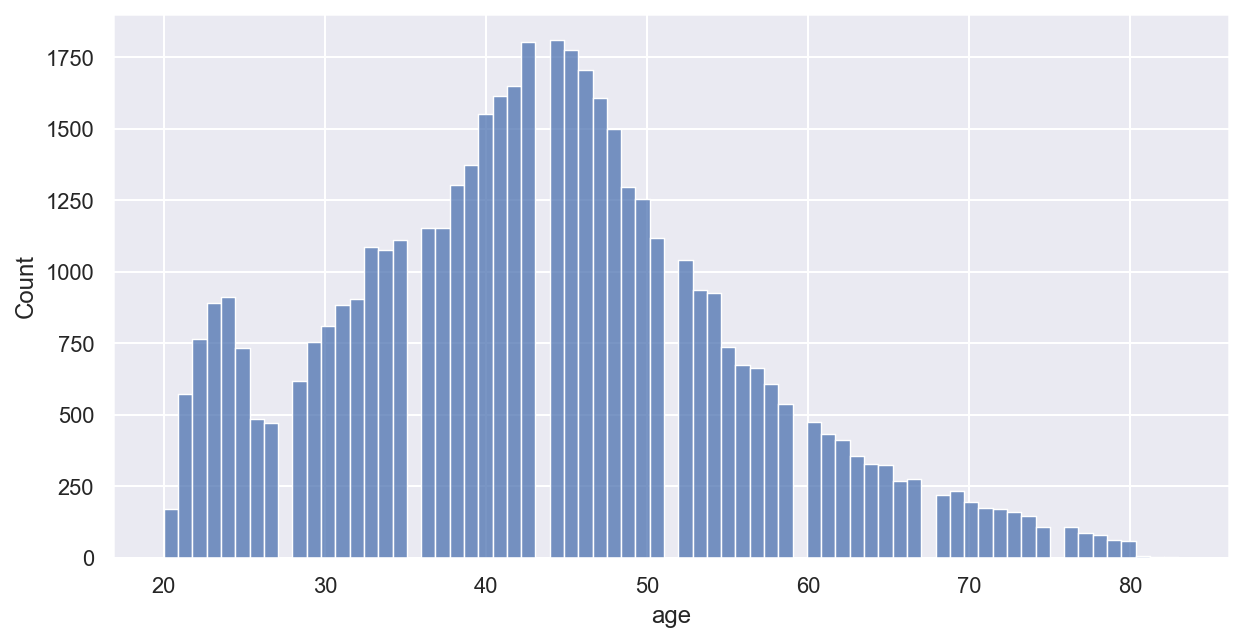

In [28]:
aux1 = df4.loc[ df4['response'] == 1, 'age' ]
sns.histplot( aux1 );

#### annual_premium

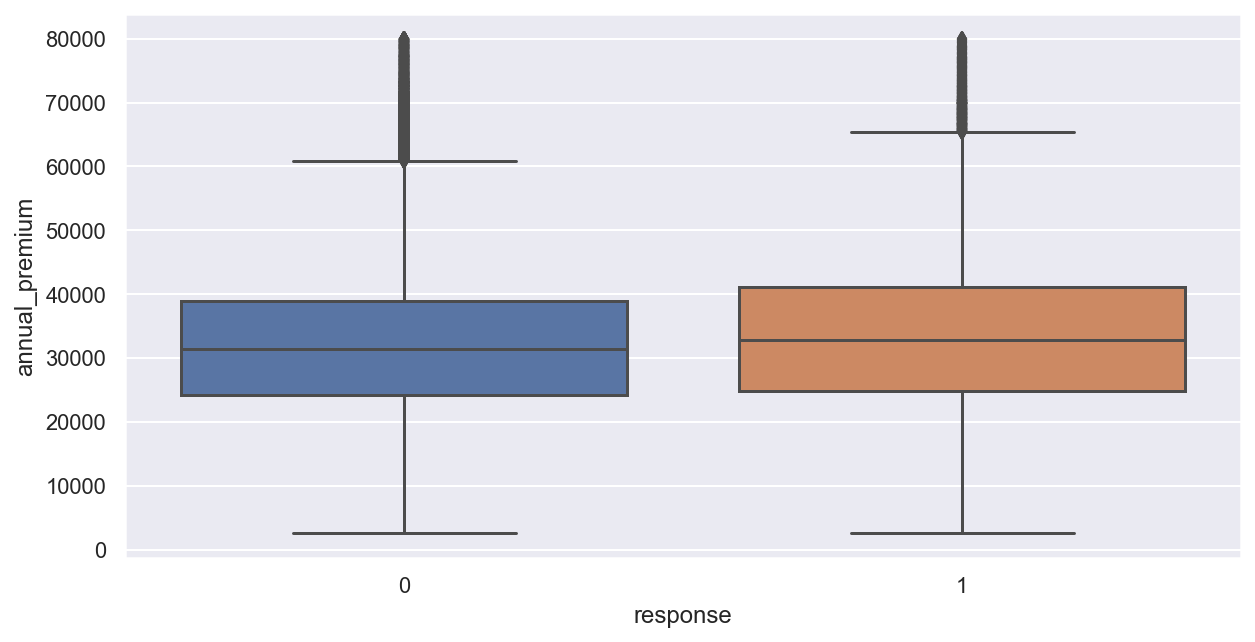

In [29]:
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x = 'response', y = 'annual_premium', data=aux );

**Not interested ( response = 0 )**

**Interested ( response = 1 )**

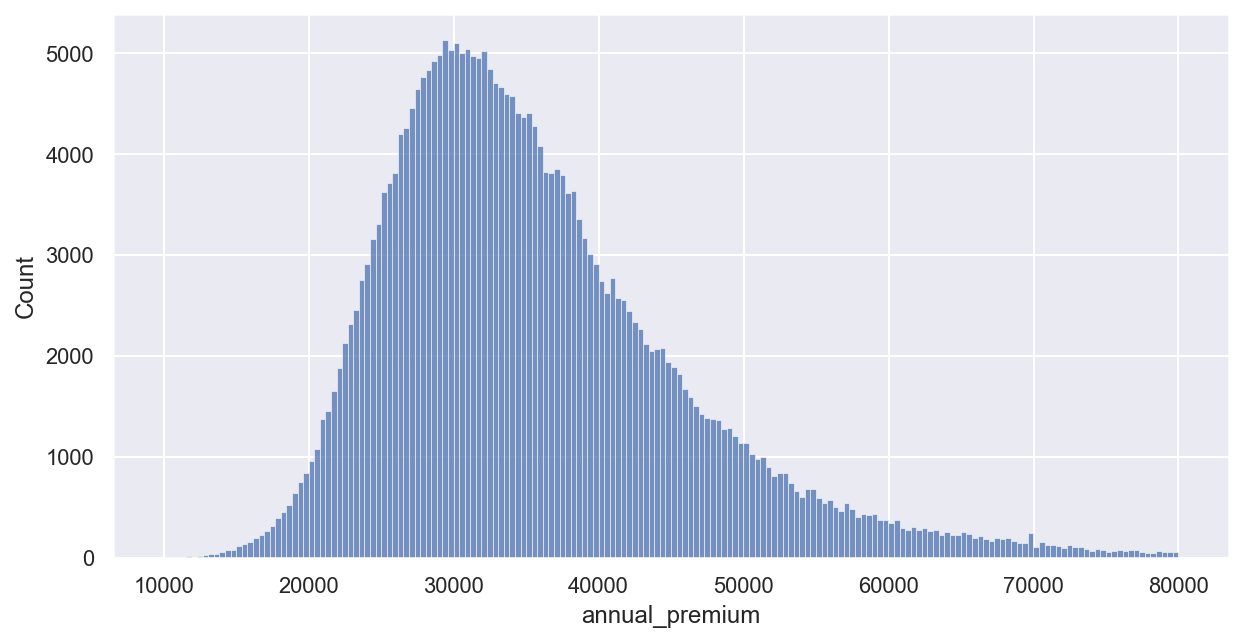

In [30]:
aux1 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

not_interested = aux1.loc[df4['response'] == 0, 'annual_premium']
sns.histplot( not_interested );

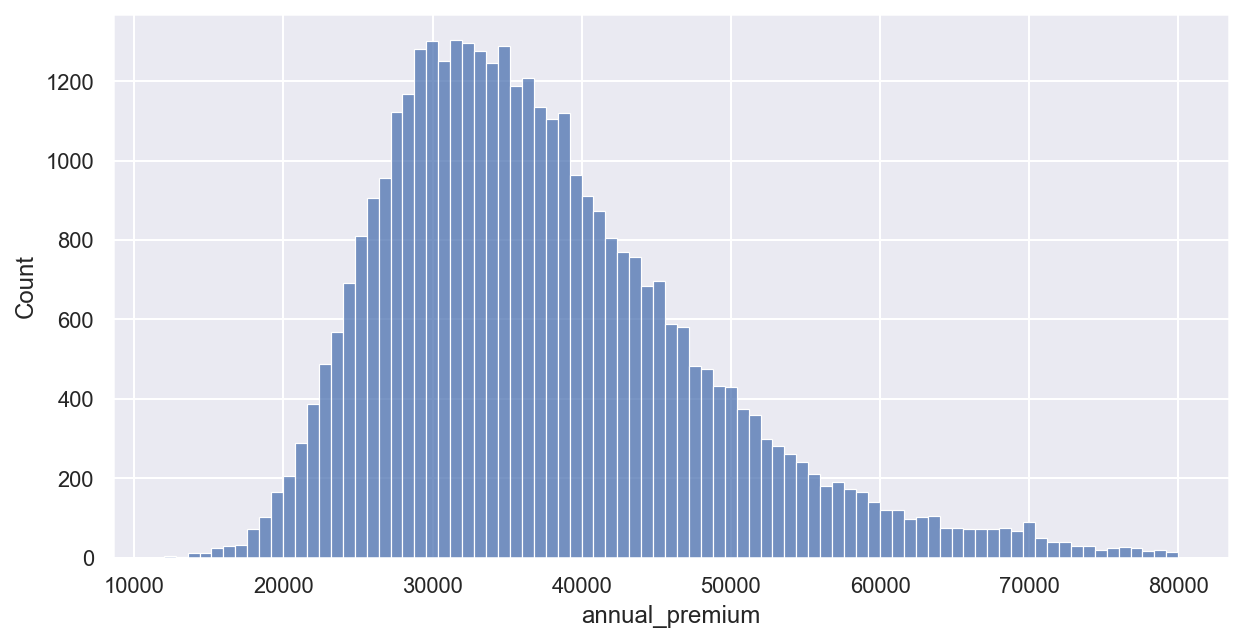

In [31]:
interested = aux1.loc[df4['response'] == 1, 'annual_premium']
sns.histplot( interested );

#### vintage

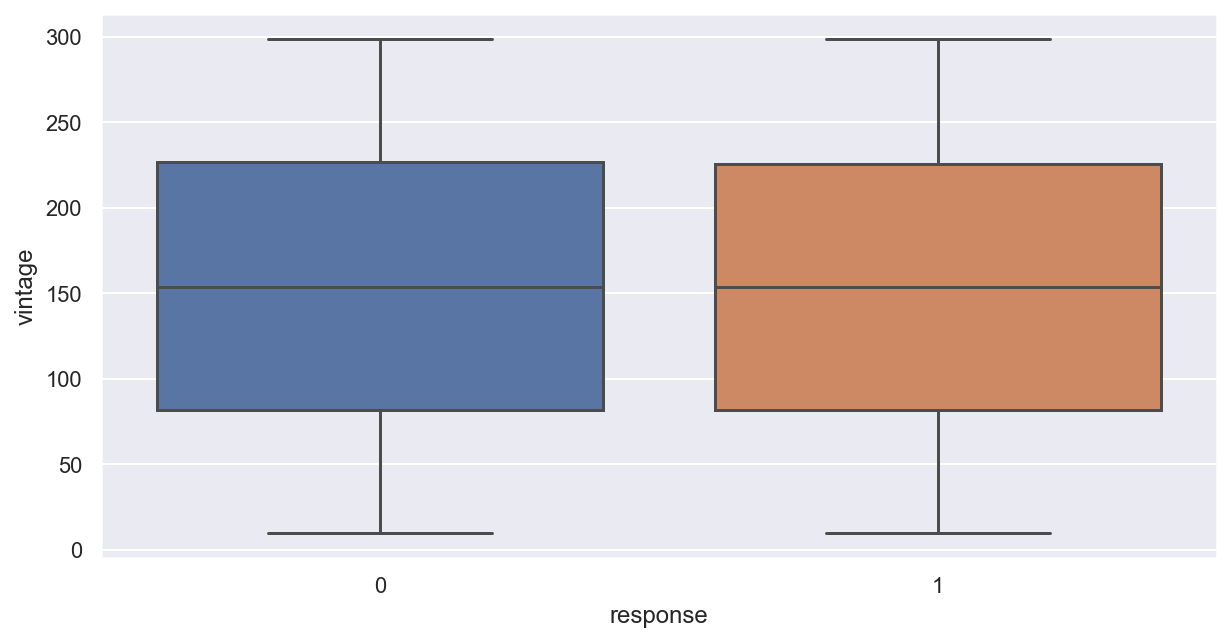

In [32]:
sns.boxplot( x = 'response', y = 'vintage', data=df4 );

**Not interested ( response = 0 )**

**Interested ( response = 1 )**

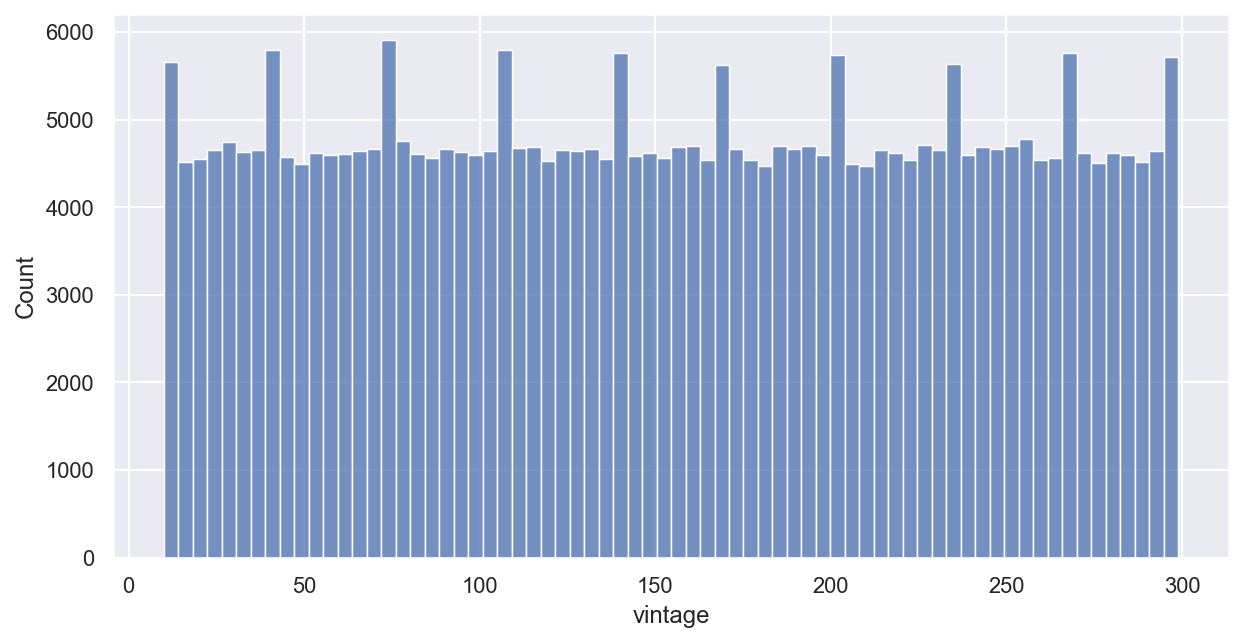

In [33]:
aux0 = df4.loc[ df4['response'] == 0, 'vintage' ]
sns.histplot( aux0 );

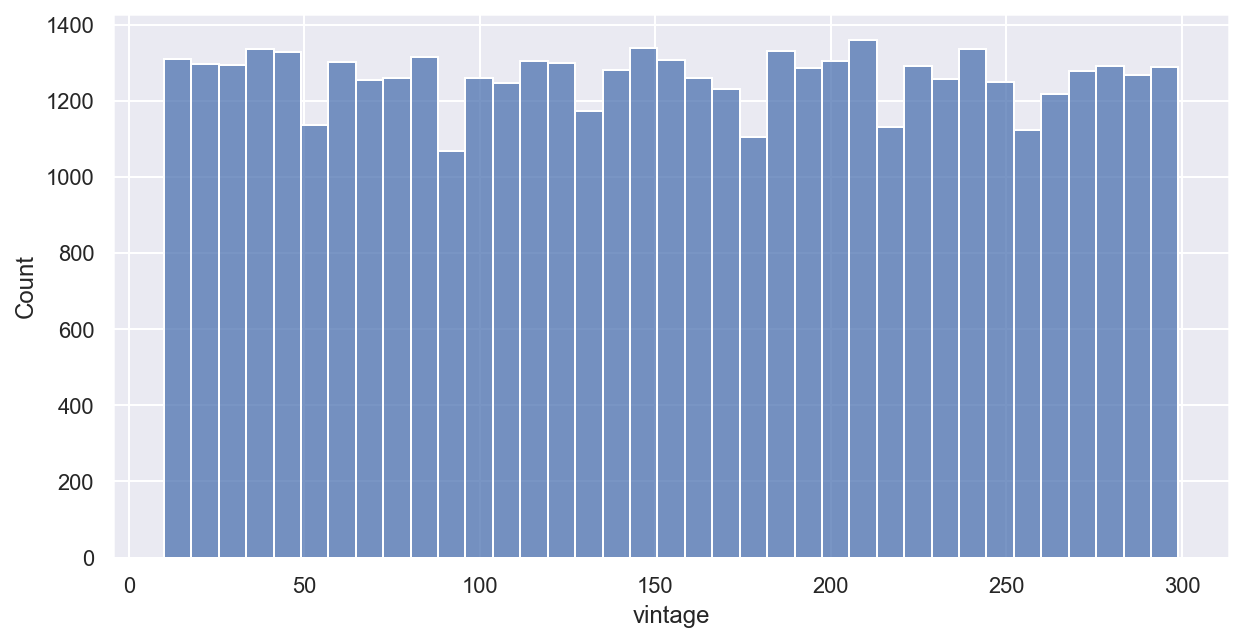

In [34]:
aux1 = df4.loc[ df4['response'] == 1, 'vintage' ]
sns.histplot( aux1 );

### 4.1.2. Categorical Attributes

#### gender

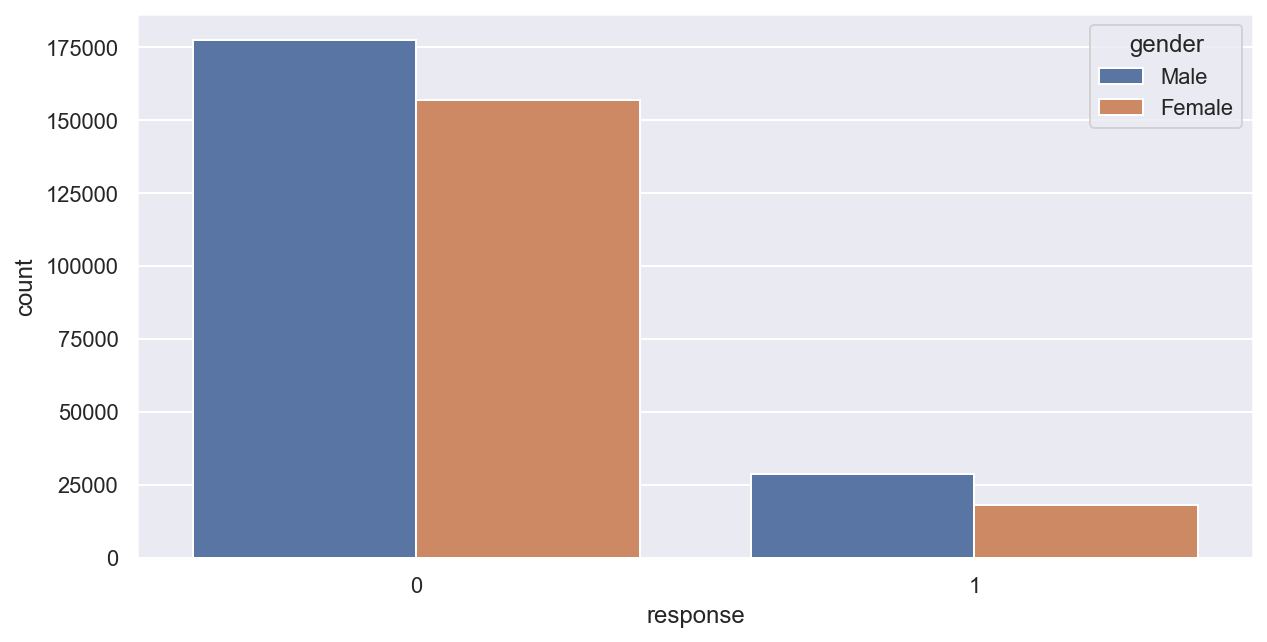

In [35]:
aux = df4[['gender','response']].value_counts().reset_index()
aux.columns = ['gender','response','count']
sns.barplot( x = 'response', y = 'count', hue = 'gender', data=aux );

#### region_code

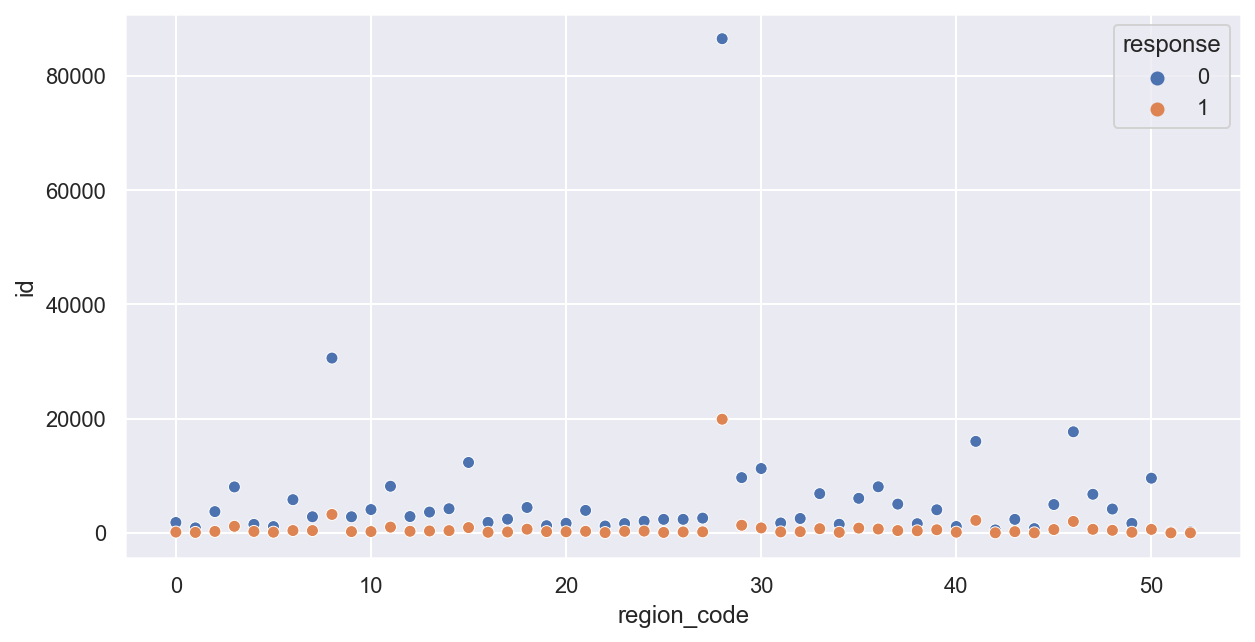

In [36]:
aux = df4[['id','region_code','response']].groupby( ['region_code','response'] ).count().reset_index()
sns.scatterplot( x = 'region_code', y='id', hue='response', data=aux );

#### policy_sales_channel

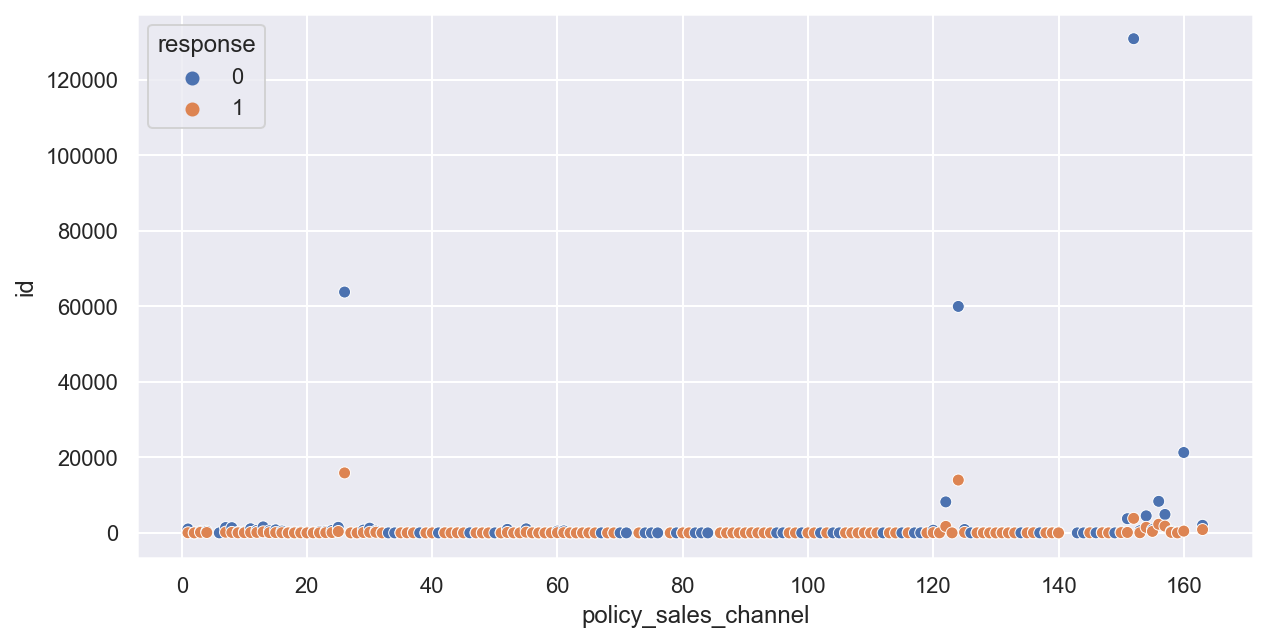

In [37]:
aux = df4[['id','policy_sales_channel','response']].groupby( ['policy_sales_channel','response'] ).count().reset_index()
sns.scatterplot( x='policy_sales_channel', y='id', hue='response', data=aux );

#### previously_insured

In [38]:
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.775,0.225
1,0.999,0.001


#### driving_license

In [39]:
df4[['id','driving_license','response']].groupby(['driving_license','response']).count().reset_index()

,driving_license,response,id
0,0,0,771
1,0,1,41
2,1,0,333628
3,1,1,46669


#### vehicle_age

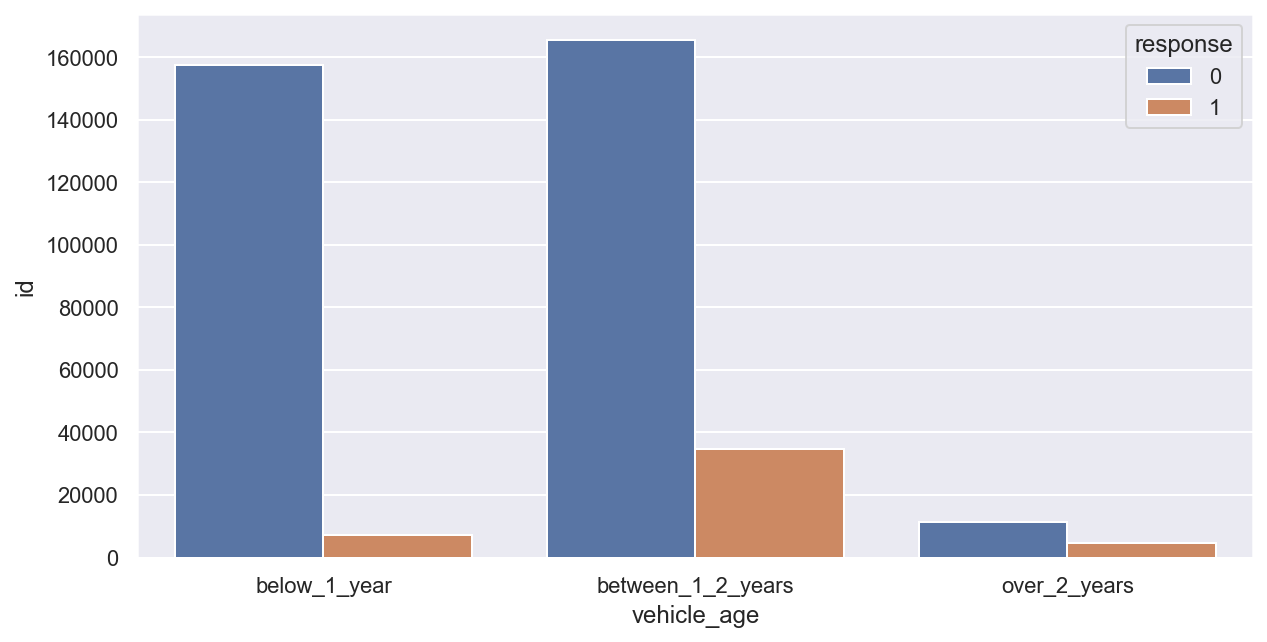

In [40]:
aux = df4[['id','vehicle_age','response']].groupby(['vehicle_age','response']).count().reset_index()
sns.barplot( x='vehicle_age', y='id', hue='response', data=aux );

#### vehicle_damage

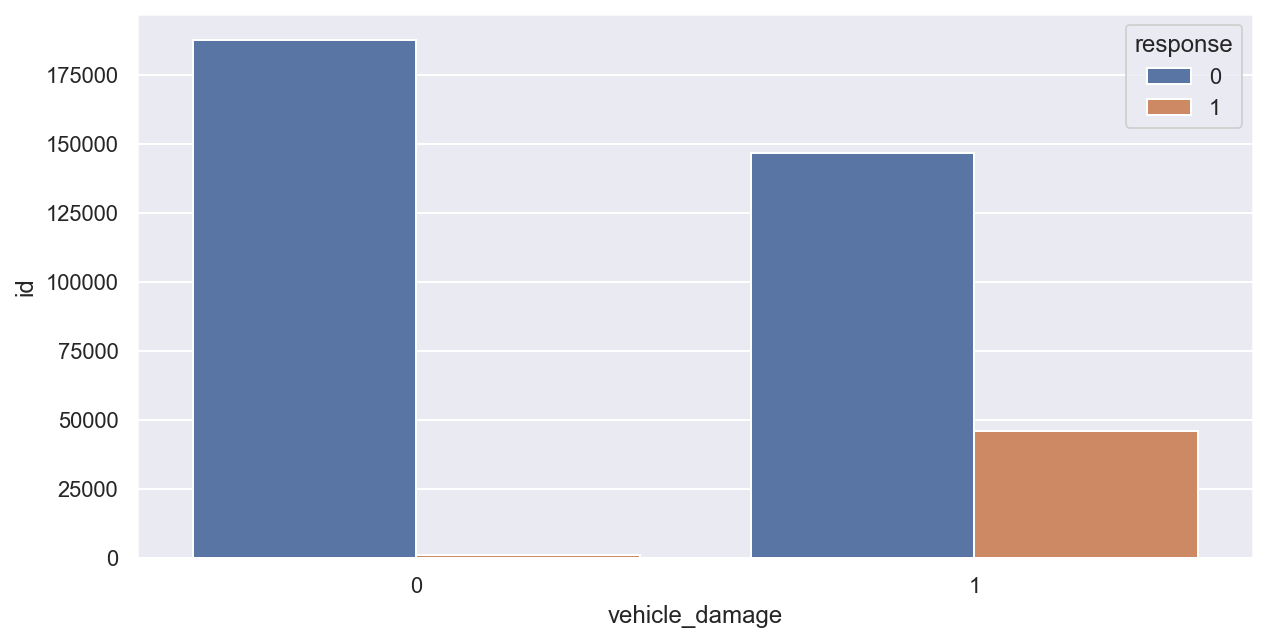

In [41]:
aux = df4[['id','vehicle_damage','response']].groupby( ['vehicle_damage','response'] ).count().reset_index()
sns.barplot( x='vehicle_damage', y='id', hue='response', data=aux );

## 4.2. Bivarieted analysis

**Hypothesis list:**

**H1**: Woman customers have more interest in buying vehicle insurance.

**H2**: Customers with cars below 1 year have more interest in buying vehicle insurance.

**H3**: Customers over 40 years old have more interest in buying vehicle insurance.

**H4**: Customers with health insurance for more than 100 days have more interest in buying vehicle insurance.

**H5**: Customers that had their cars damaged have more interest in buying vehicle insurance.

**H6**: Customers over 50 years old tend to already have vehicle insurance. 

**H7**: Customers who pay more than 50.000 in health insurance tend to already have vehicle insurance.

**H8**: Customers who pay less than 5.000 tend to not have interest in vehicle insurance.

### **H1**: Woman customers have more interest in buying vehicle insurance.
**FALSE**. Of the total number of customers interested in buying vehicle insurance, only 38.93% are women.

In [42]:
aux_h1 = df4[['id','gender','response']].groupby(['gender','response']).count().reset_index()
aux_h1 = aux_h1.loc[[1,3]]

total = aux_h1['id'].sum()
aux_h1['percentage'] = aux_h1['id'].apply( lambda x: ( x / total ) * 100 )
aux_h1

,gender,response,id,percentage
1,Female,1,18185,38.932
3,Male,1,28525,61.068


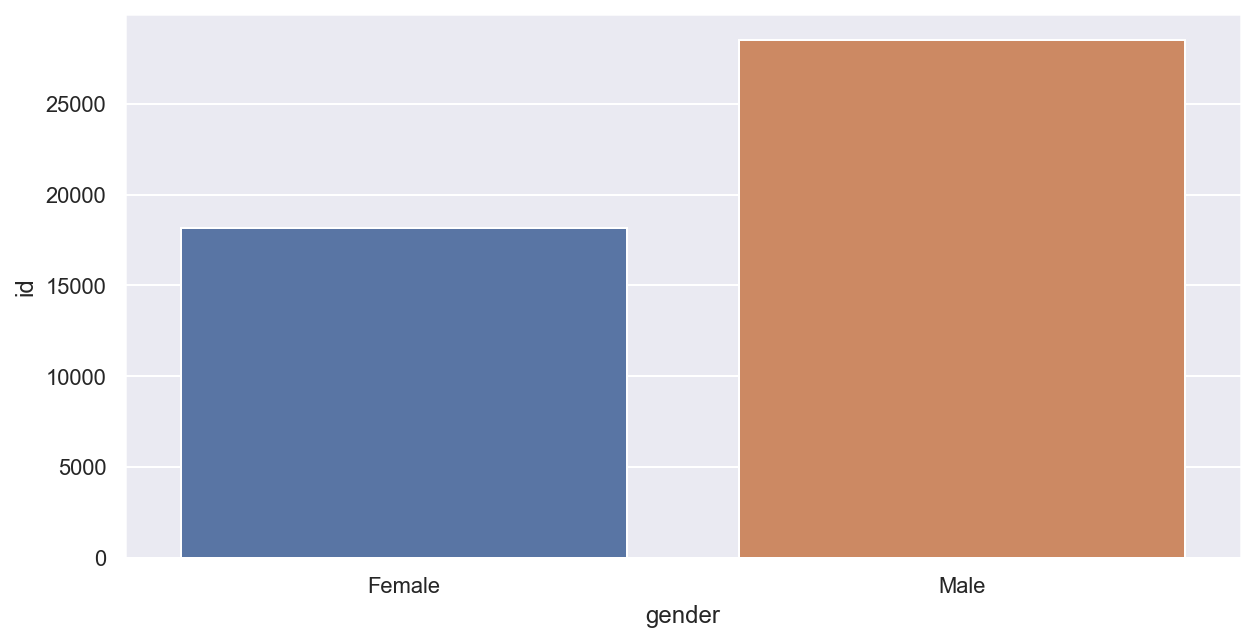

In [43]:
sns.barplot( x='gender', y='id', data=aux_h1 );

### **H2**:  Customers with cars below 1 year have more interest in buying vehicle insurance.
**FALSE**. Of the total number of customers interested, the ones with a car younger than 1 year represent only 15.41%.

In [44]:
aux_h2 = df4[['id','vehicle_age','response']].groupby(['vehicle_age','response']).count().reset_index()
aux_h2 = aux_h2.loc[[1, 3, 5]]

total = aux_h2['id'].sum()
aux_h2['percentage'] = aux_h2['id'].apply( lambda x: ( x / total ) * 100 )
aux_h2

,vehicle_age,response,id,percentage
1,below_1_year,1,7202,15.419
3,between_1_2_years,1,34806,74.515
5,over_2_years,1,4702,10.066


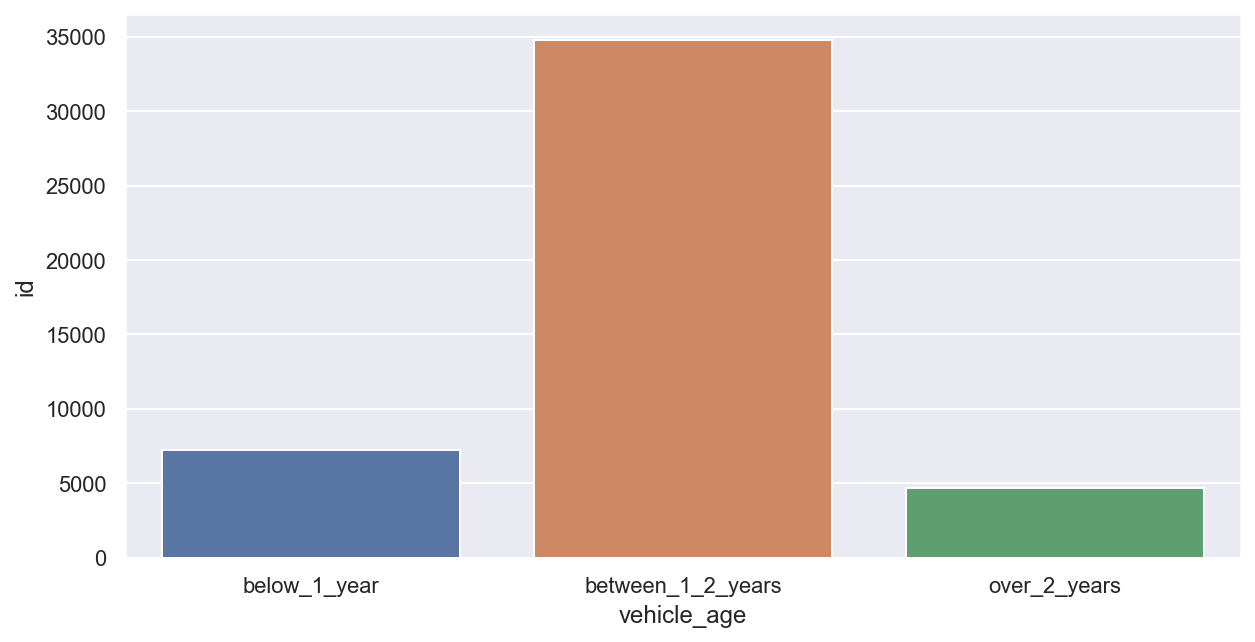

In [45]:
sns.barplot( x='vehicle_age', y='id', data=aux_h2 );

### **H3**: Customers over 40 years old have more interest in buying vehicle insurance.
**FALSE**. Of the total number of customers interested, only 9.98% are over 40 years old.

In [46]:
aux_h3 = df4[['id','age','response']].groupby(['age','response']).count().reset_index()
aux_h3 = aux_h3[aux_h3['response'] == 1].reset_index( drop=True )

aux_h3['how_old'] = aux_h3['age'].apply( lambda x: 'under_40' if x < 40 else 'over_40' )
aux_h3 = aux_h3[['how_old','id']].groupby('how_old').sum().reset_index()

aux_h3['percentage'] = aux_h3['id'].apply( lambda x: ( x / total * 100 ) )
aux_h3

,how_old,id,percentage
0,over_40,29480,63.113
1,under_40,17230,36.887


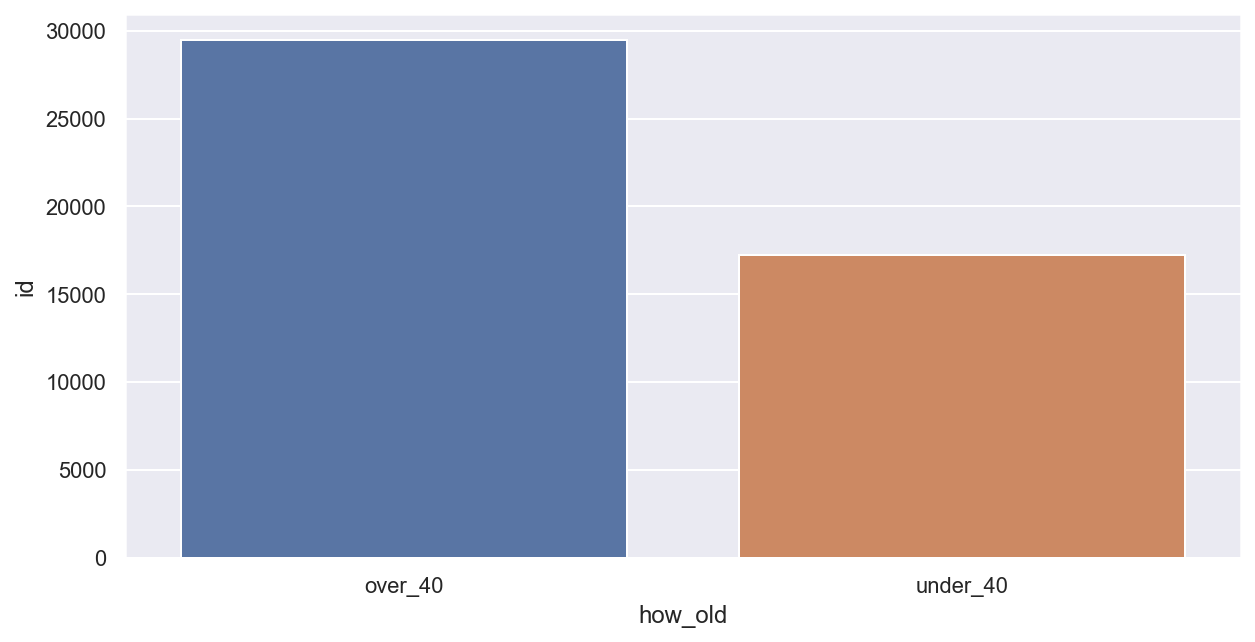

In [47]:
sns.barplot( x='how_old', y='id', data=aux_h3 );

**Propensity of purchasing per age**

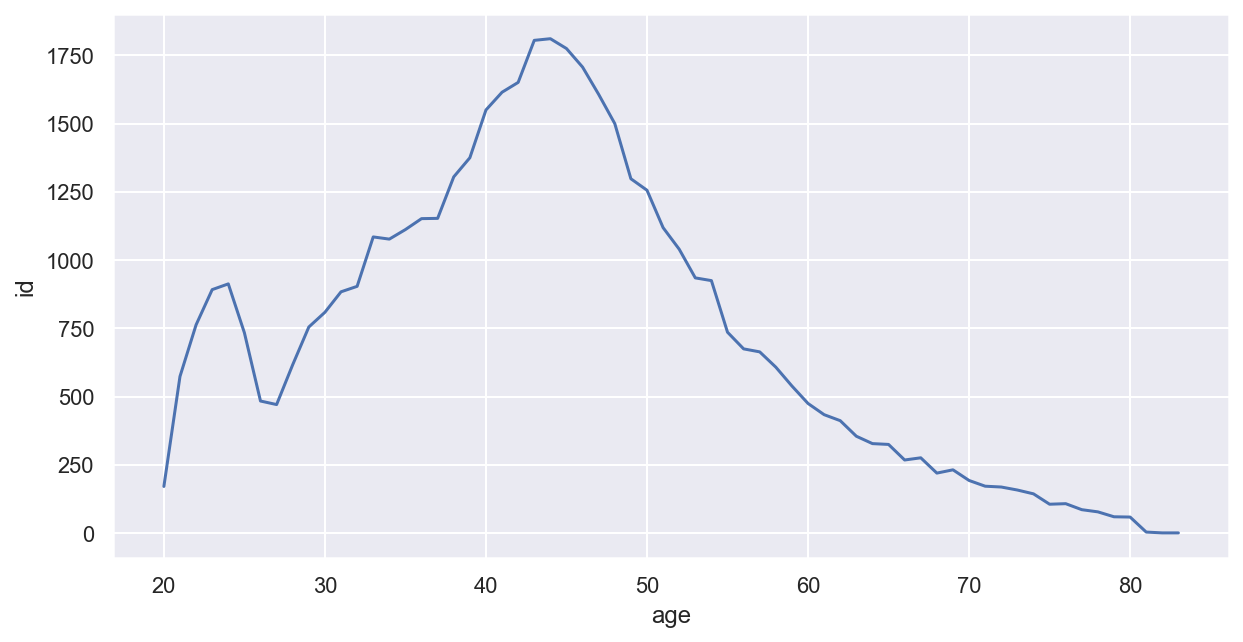

In [48]:
aux_age = df4[['id','age','response']].groupby(['age','response']).count().reset_index()
aux_age = aux_age[aux_age['response'] == 1].reset_index( drop=True )

sns.lineplot( x='age', y='id', data=aux_age );

### **H4**: Customers with health insurance for more than 100 days have more interest in buying vehicle insurance.
**TRUE**. Of the total number of customers interested, 68,57% have health insurance for more than 100 days.

In [49]:
aux_h4 = df4[['id','vintage','response']].groupby(['vintage','response']).count().reset_index()
aux_h4 = aux_h4[aux_h4['response'] == 1]

aux_h4['days'] = aux_h4['vintage'].apply( lambda x: 'under_100' if x <= 100 else 'over_100' )
aux_days = aux_h4[['days','id']].groupby('days').sum().reset_index()
aux_days['percentage'] = aux_days['id'].apply( lambda x: ( x / total * 100 ) )
aux_days

,days,id,percentage
0,over_100,32030,68.572
1,under_100,14680,31.428


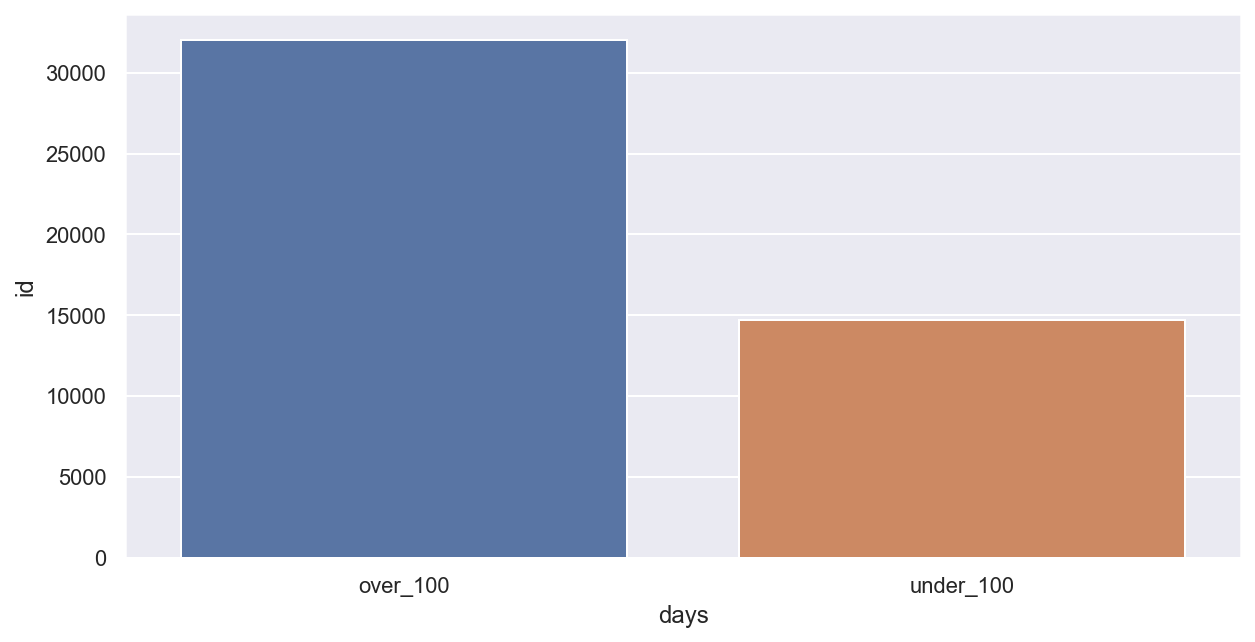

In [50]:
sns.barplot( x='days', y='id', data=aux_days );

**Propensity of purchasing per vintage**

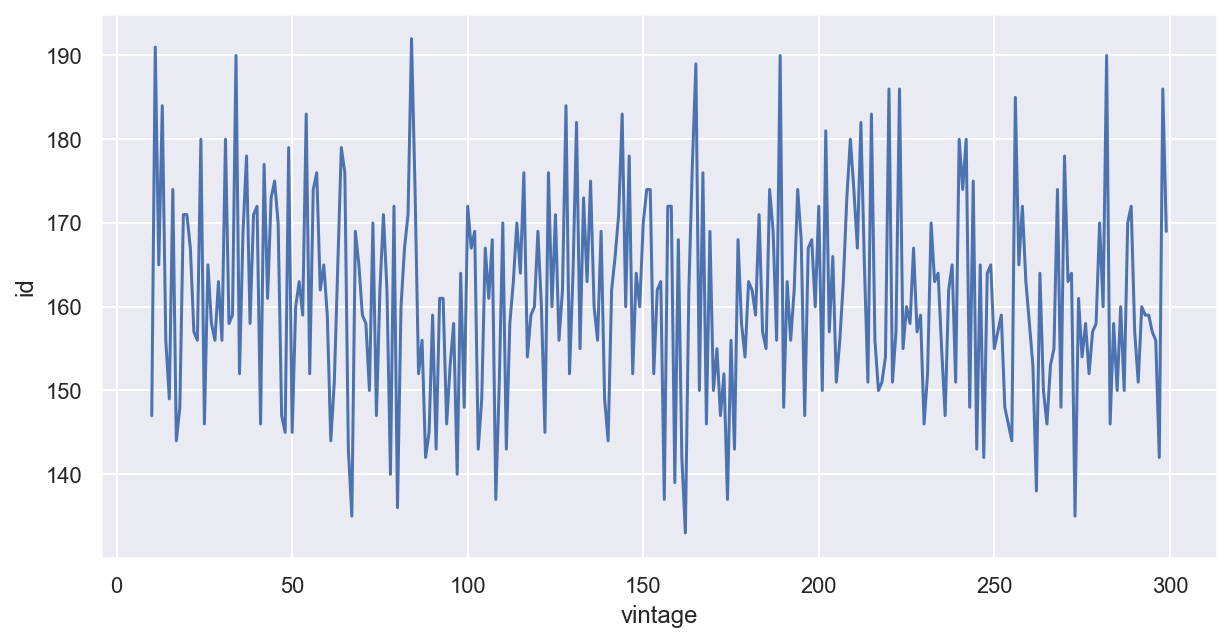

In [51]:
sns.lineplot( x='vintage', y='id', data=aux_h4 );

It is noticed that, despite the positive conclusion of the hypothesis, there is no way to reach a conclusion due the constant behavior of the propensity graph.

### **H5**:  Customers that had their cars damaged have more interest in buying vehicle insurance.
**TRUE**. Almost all customers who are interested in buying vehicle insurance have already had their car damaged.

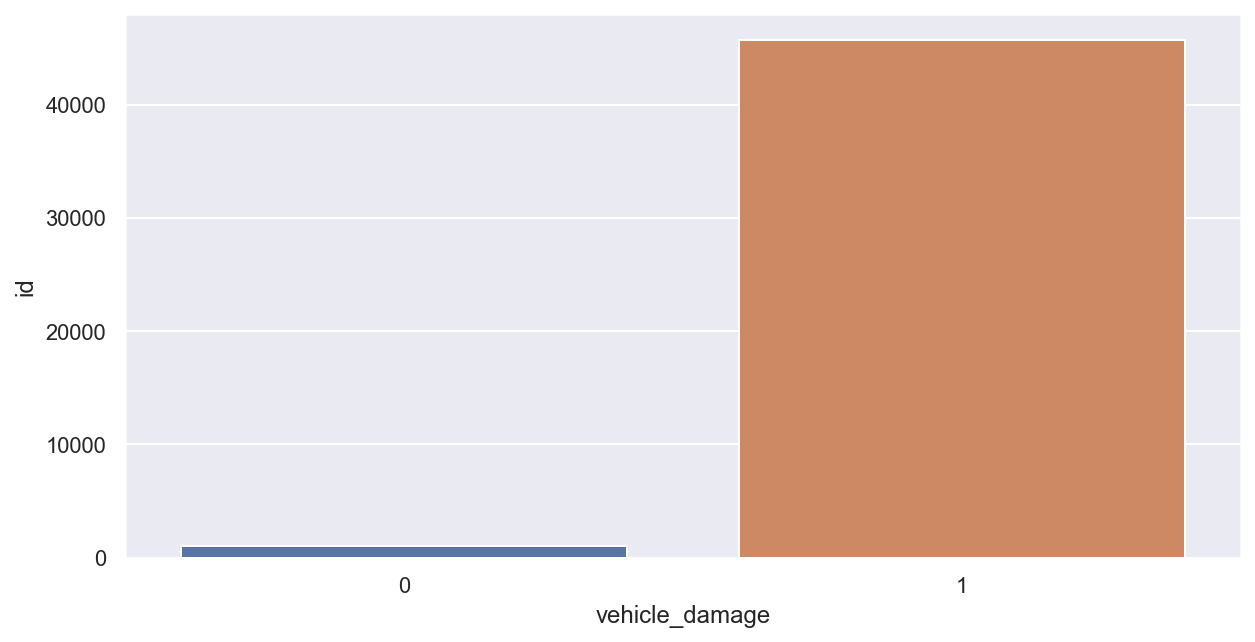

In [52]:
aux_h5 = df4[['id','vehicle_damage','response']].groupby(['vehicle_damage','response']).count().reset_index()
aux_h5 = aux_h5.loc[[1, 3]]

sns.barplot( x='vehicle_damage', y='id', data=aux_h5 );

### **H6**:Customers over 50 years old tend to already have vehicle insurance.
**FALSE**. In comparison with younger clients, they tend not to have.

In [53]:
aux_h7 = df4[['id','age','previously_insured']].groupby(['age','previously_insured']).count().reset_index()
aux_h7['how_old'] = aux_h7['age'].apply( lambda x: 'under_50' if x < 50 else 'over_50' )
aux1 = aux_h7[['id','how_old','previously_insured']].groupby(['how_old','previously_insured']).sum().reset_index()
aux1

,how_old,previously_insured,id
0,over_50,0,63595
1,over_50,1,31212
2,under_50,0,142886
3,under_50,1,143416


In [54]:
aux_over = aux1.loc[[0,1]]

total_over_50 = aux_over['id'].sum()

aux_over['percentage'] = aux_over['id'].apply( lambda x: ( x / total_over_50 * 100) )
aux_over

,how_old,previously_insured,id,percentage
0,over_50,0,63595,67.078
1,over_50,1,31212,32.922


In [55]:
aux_under = aux1.loc[[2,3]]

total_under_50 = aux_under['id'].sum()

aux_under['percentage'] = aux_under['id'].apply( lambda x: ( x / total_under_50 * 100) )
aux_under

,how_old,previously_insured,id,percentage
2,under_50,0,142886,49.907
3,under_50,1,143416,50.093


### **H7**: Customers who pay more than 50.000 in health insurance tend to already have vehicle insurance.
**FALSE**. Only 39% of customers that pays more than 50.000 already have vehicle insurance.

**Mais de $50000**

In [56]:
aux1 = df4[df4['annual_premium'] > 50000 ]
a = aux1[['id','previously_insured']].groupby('previously_insured').count().reset_index()
total_a = a['id'].sum()
a['percentage'] = a['id'].apply( lambda x: ( x / total_a ) * 100 )
a

,previously_insured,id,percentage
0,0,19503,60.561
1,1,12701,39.439


**Menos de $50.000**

In [57]:
aux2 = df4[df4['annual_premium'] <= 50000 ]
b = aux2[['id','previously_insured']].groupby('previously_insured').count().reset_index()
total_b = b['id'].sum()
b['percentage'] = b['id'].apply( lambda x: ( x / total_b ) * 100 )
b

,previously_insured,id,percentage
0,0,186978,53.590
1,1,161927,46.410


### **H8**: Customers who pay less than 5.000 tend to not have interest in vehicle insurance.
**FALSE**. The proportion is similar.

**Less than $5.000**

In [58]:
aux1 = df4[df4['annual_premium'] > 5000 ]
a = aux1[['id','response']].groupby('response').count().reset_index()
total_a = a['id'].sum()
a['percentage'] = a['id'].apply( lambda x: ( x / total_a ) * 100 )
a

,response,id,percentage
0,0,278027,87.919
1,1,38205,12.081


**More de $5.000**

In [59]:
aux2 = df4[df4['annual_premium'] <= 5000 ]
b = aux2[['id','response']].groupby('response').count().reset_index()
total_b = b['id'].sum()
b['percentage'] = b['id'].apply( lambda x: ( x / total_b ) * 100 )
b

,response,id,percentage
0,0,56372,86.891
1,1,8505,13.109


## 4.3. Multivarieted analysis

In [60]:
attributes = df4.drop( ['id'], axis=1 )

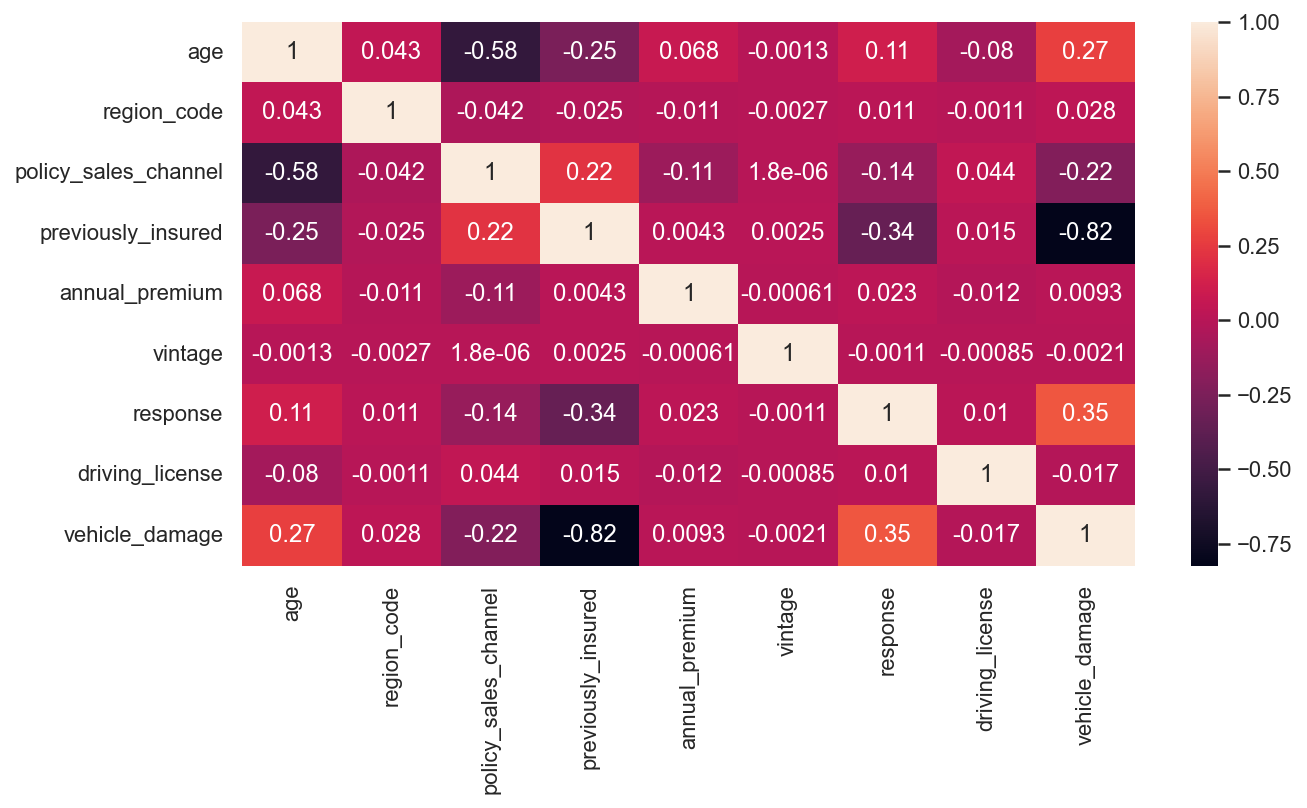

In [61]:
correlation = attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

# 5.0. DATA PREPARATION

In [62]:
# Train and validation split

X_general = df4.drop( 'response', axis=1 )
Y_general = df4['response']

x_train, x_validation, y_train, y_validation = ms.train_test_split( X_general, Y_general, test_size=0.20 )

df5 = pd.concat( [ x_train, y_train ], axis=1 )

## 5.1. Normalization

In [63]:
# annual premium - normal curve

ss = pp.StandardScaler()

df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
pickle.dump( ss, open( '/Users/mathe/Repos_ComunidadeDS/health_insurance_cross_sell/src/feature_preparation/annual_scaler.pkl', 'wb' ) )

## 5.2. Rescaling

In [64]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform( df5[['age']].values )
pickle.dump( mms_age, open( '/Users/mathe/Repos_ComunidadeDS/health_insurance_cross_sell/src/feature_preparation/age_scaler.pkl', 'wb' ) )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump( mms_vintage, open( '/Users/mathe/Repos_ComunidadeDS/health_insurance_cross_sell/src/feature_preparation/vintage_scaler.pkl', 'wb' ) )

## 5.3. Encoding

In [65]:
# region code - Target Encoding
target_encoding_region_code = df5.groupby( 'region_code' )['response'].mean()

df5['region_code'] = df5['region_code'].map( target_encoding_region_code )
pickle.dump( target_encoding_region_code, open( '/Users/mathe/Repos_ComunidadeDS/health_insurance_cross_sell/src/feature_preparation/region_code_encoding.pkl', 'wb' ) )

# policy sales channel - Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 )

df5['policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( '/Users/mathe/Repos_ComunidadeDS/health_insurance_cross_sell/src/feature_preparation/policy_sales_encoding.pkl', 'wb' ) )

# gender
le = pp.LabelEncoder()

df5['gender'] = le.fit_transform( df5['gender'] )
pickle.dump( le, open( '/Users/mathe/Repos_ComunidadeDS/health_insurance_cross_sell/src/feature_preparation/gender_encoding.pkl', 'wb' ) )

# vehicle age - One Hot Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

## Validation Preparation

In [66]:
# annual premium - normal curve
x_validation['annual_premium'] = ss.fit_transform( x_validation[['annual_premium']].values )

# age
x_validation['age'] = mms_age.fit_transform( x_validation[['age']].values )

# vintage
x_validation['vintage'] = mms_vintage.fit_transform( x_validation[['vintage']].values )

# region code - Target Encoding
x_validation['region_code'] = x_validation['region_code'].map( target_encoding_region_code )

# policy sales channel - Frequency Encoding
x_validation['policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# gender
x_validation['gender'] = le.fit_transform( x_validation['gender'] )

# vehicle age - One Hot Encoding
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# fill na
x_validation = x_validation.fillna( 0 )

# 6.0. FEATURE SELECTION

In [67]:
# # model
# forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# # training
# x_train_fselection = df5.drop( ['id','response'], axis=1 )
# y_train_fselection = y_train.values
# forest.fit( x_train_fselection, y_train_fselection )

In [68]:
# importances = forest.feature_importances_
# std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
# indices = np.argsort( importances )[::-1]

# # print the feature ranking
# df = pd.DataFrame()

# print( 'Feature Ranking:\n' )
# for i, j in zip( x_train_fselection,forest.feature_importances_ ):
#     aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
#     df = pd.concat( [df, aux], axis=0 )
    
# print( df.sort_values( 'importance', ascending=False ) ) 

# # plot the impurity-based feature importances of the forest
# plt.figure()
# plt.title( 'Feature importances' )
# plt.bar( range( x_train_fselection.shape[1] ), importances[indices], color='r', yerr=std[indices], align='center' )
# plt.xticks( range(x_train_fselection.shape[1]), indices )
# plt.xlim( [-1, x_train_fselection.shape[1]] )
# plt.show()

# 7.0. MACHINE LEARNING

In [69]:
selected_cols = [ 'vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage',
                  'policy_sales_channel', 'previously_insured' ]

x_train = df5[ selected_cols ]
x_val = x_validation[ selected_cols ]
y_val = y_validation.copy()

## 7.1. KNN

In [70]:
# model
knn_model = nh.KNeighborsClassifier( n_neighbors=10 )

# model training
knn_model.fit( x_train, y_train )

# prediction
yhat_knn = knn_model.predict_proba( x_val )

### Precision and Recall at K metrics

In [71]:
knn_metrics = at_k_metrics( 'KNN', x_validation, y_validation, yhat_knn )
knn_metrics

,Precision_at_k,Recall_at_k
KNN,0.298,0.638


### Cumulative Gains and Lift curves

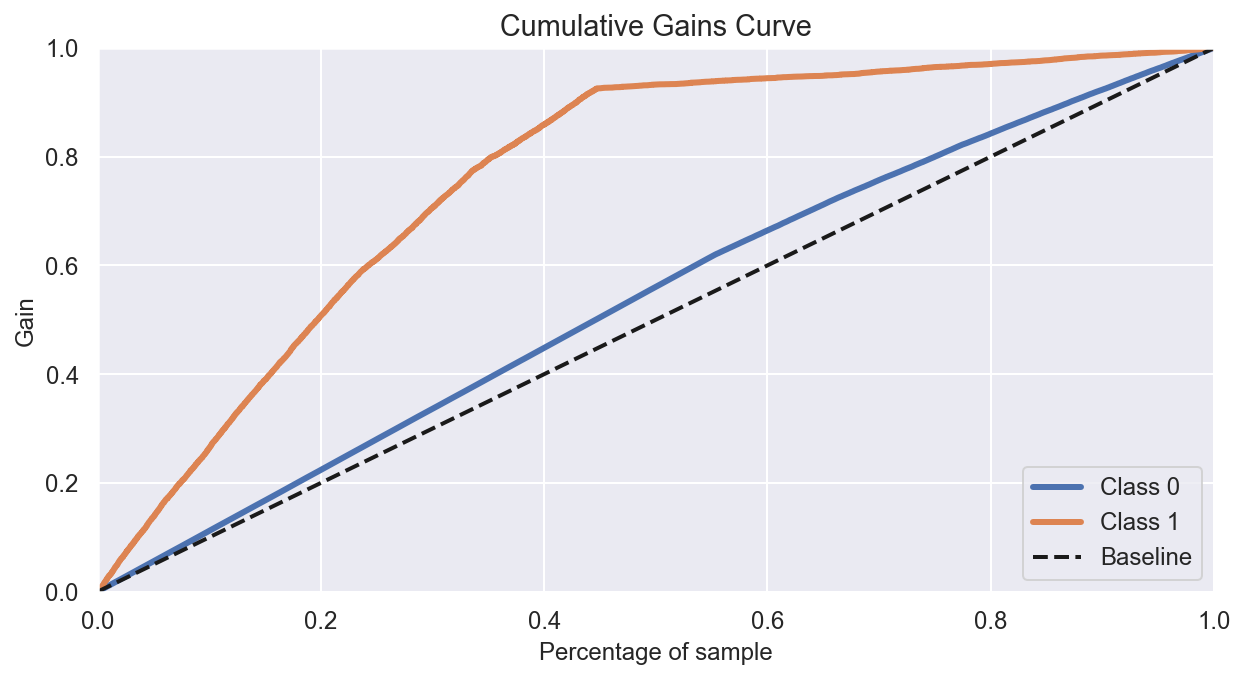

In [72]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

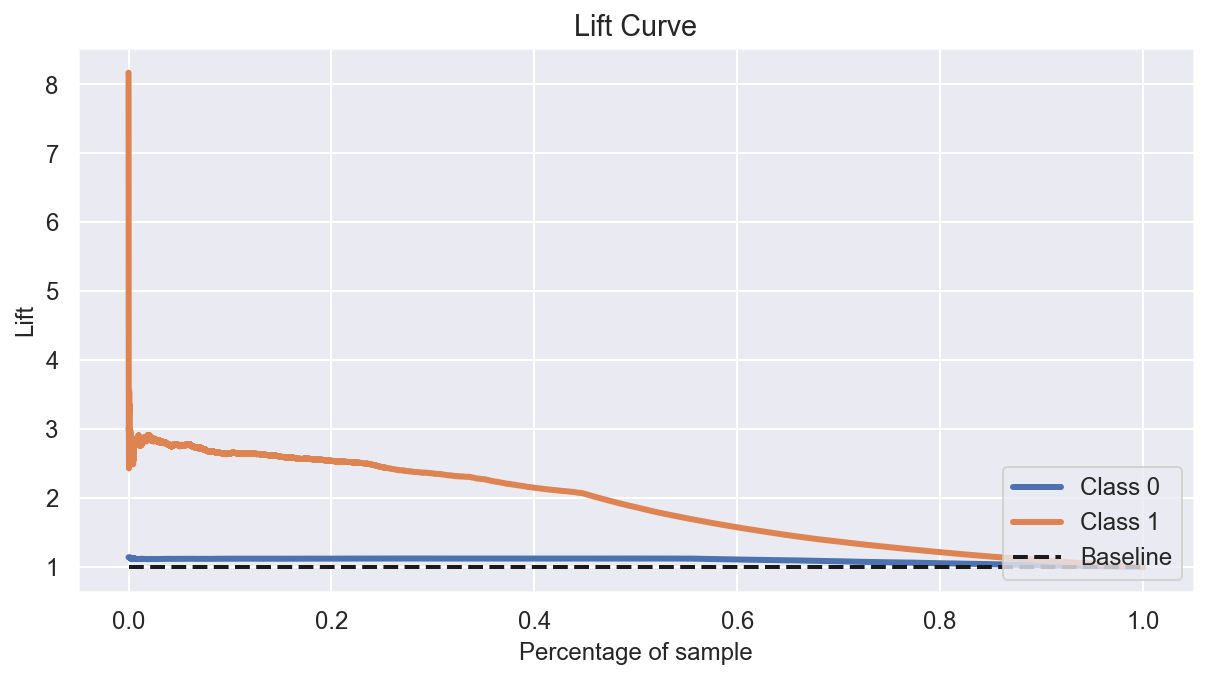

In [73]:
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

### Stratified Cross Validation

In [74]:
knn_cv = cross_validation( 'KNN', knn_model, x_train, y_train )
knn_cv

,Precision_at_k,Recall_at_k
KNN,0.28 +/- 0.0,0.76 +/- 0.0


## 7.2. Logistic Regression

In [75]:
# model
lr = lm.LogisticRegression( random_state=42 )

# model training
lr.fit( x_train, y_train )

# prediction
yhat_lr = lr.predict_proba( x_val )

### Precision and Recall at K metrics

In [76]:
lr_metrics = at_k_metrics( 'Logistic Regression', x_validation, y_validation, yhat_lr )
lr_metrics

,Precision_at_k,Recall_at_k
Logistic Regression,0.285,0.611


### Cumulative Gains and Lift curves

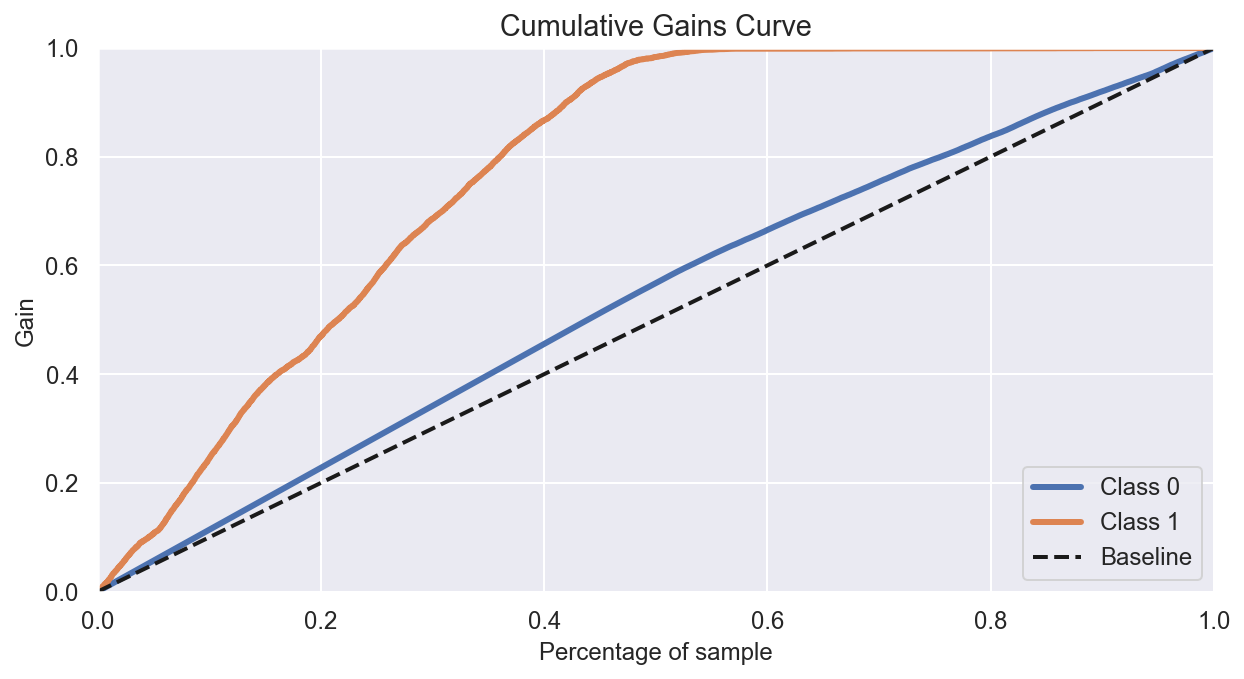

In [77]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

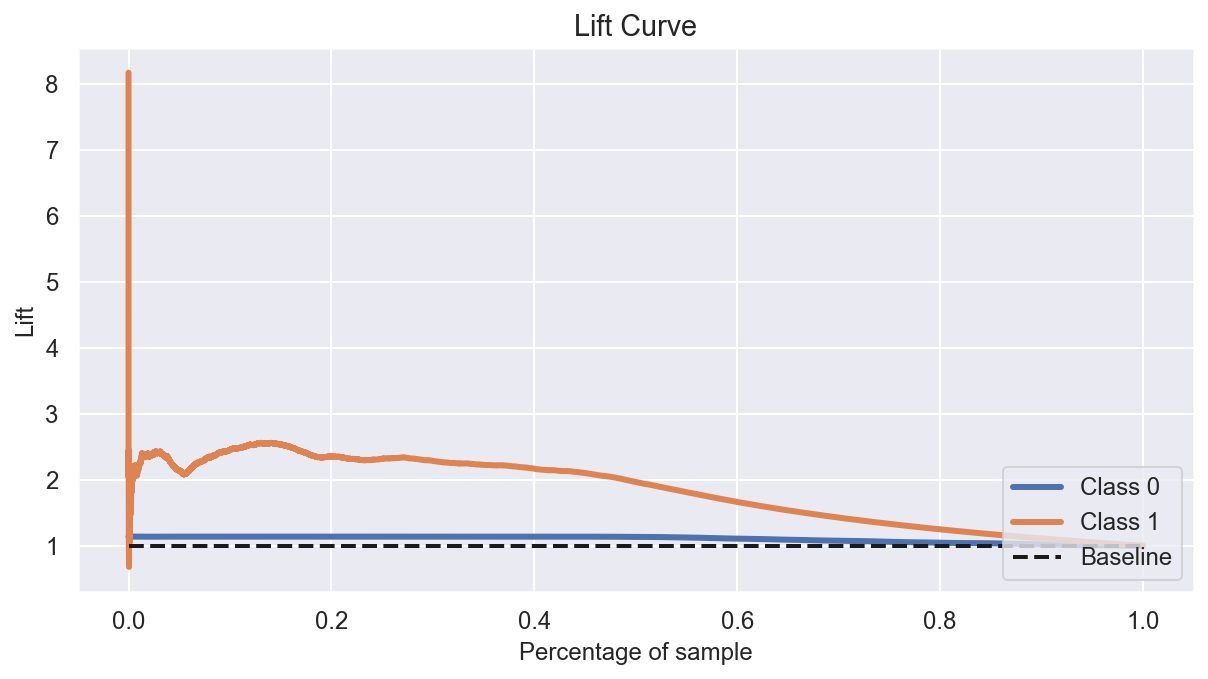

In [78]:
skplt.metrics.plot_lift_curve( y_val, yhat_lr);

### Stratified Cross Validation

In [79]:
lr_cv = cross_validation( 'Logistic Regression', lr, x_train, y_train )
lr_cv

,Precision_at_k,Recall_at_k
Logistic Regression,0.28 +/- 0.0,0.74 +/- 0.0


## 7.3. Extra Trees

In [80]:
# model
et = en.ExtraTreesClassifier( n_estimators=150, n_jobs=-1, random_state=42 )

# model training
et.fit( x_train, y_train )

# prediction
yhat_et = et.predict_proba( x_val )

### Precision and Recall at K metrics

In [81]:
et_metrics = at_k_metrics( 'Extra Trees',x_validation, y_validation, yhat_et )
et_metrics

,Precision_at_k,Recall_at_k
Extra Trees,0.3,0.643


### Cumulative Gains and Lift curves

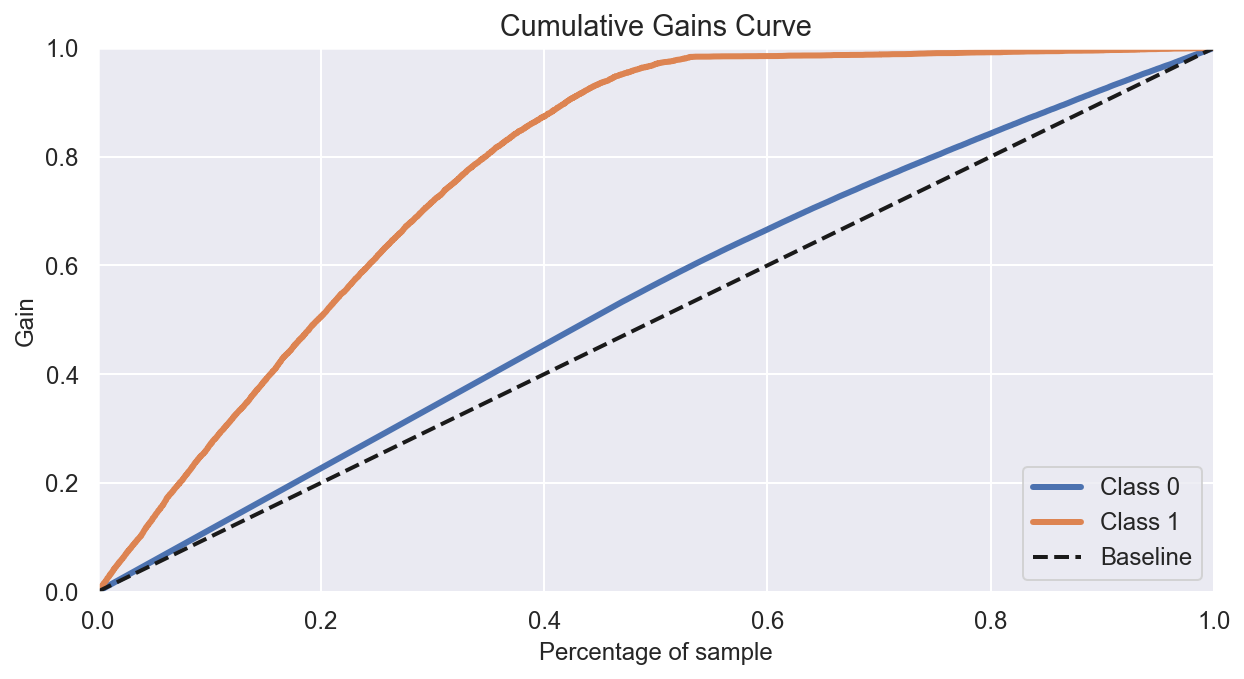

In [82]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );

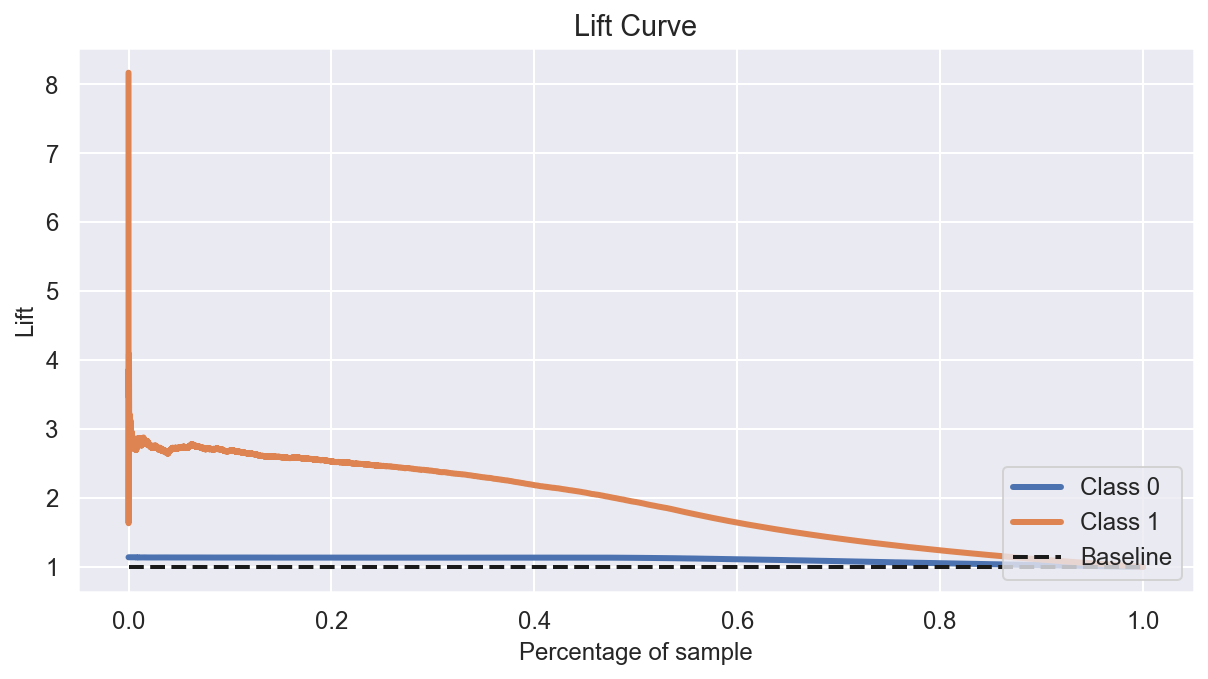

In [83]:
skplt.metrics.plot_lift_curve( y_val, yhat_et);

### Stratified Cross Validation

In [84]:
et_cv = cross_validation( 'Extra Trees', et, x_train, y_train )
et_cv

,Precision_at_k,Recall_at_k
Extra Trees,0.29 +/- 0.0,0.77 +/- 0.0


## 7.4. XGBoost 

In [85]:
# model
model_xgb = xgb.XGBClassifier(objective='binary:logistic', verbosity=0)

# training
model_xgb.fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict_proba( x_val )

### Precision and Recall at K metrics

In [86]:
model_xgb_metrics = at_k_metrics( 'XGBoost', x_validation, y_validation, yhat_xgb )
model_xgb_metrics

,Precision_at_k,Recall_at_k
XGBoost,0.328,0.702


### Cumulative Gains and Lift curves

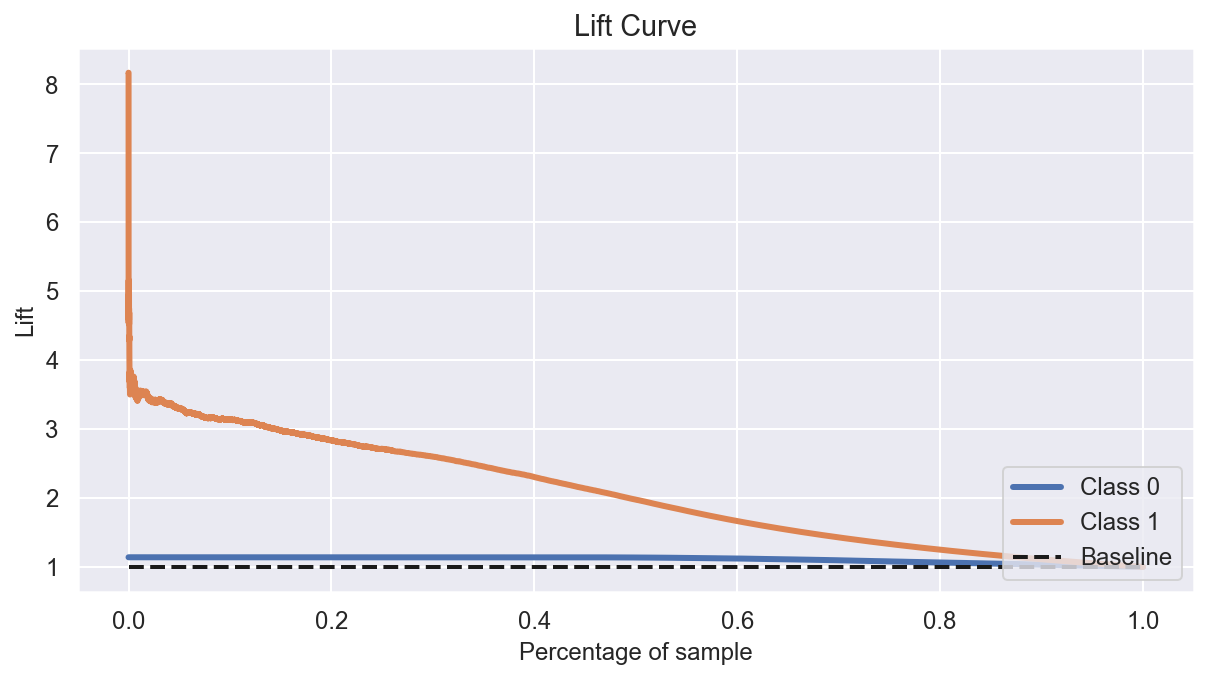

In [87]:
skplt.metrics.plot_lift_curve( y_val, yhat_xgb );

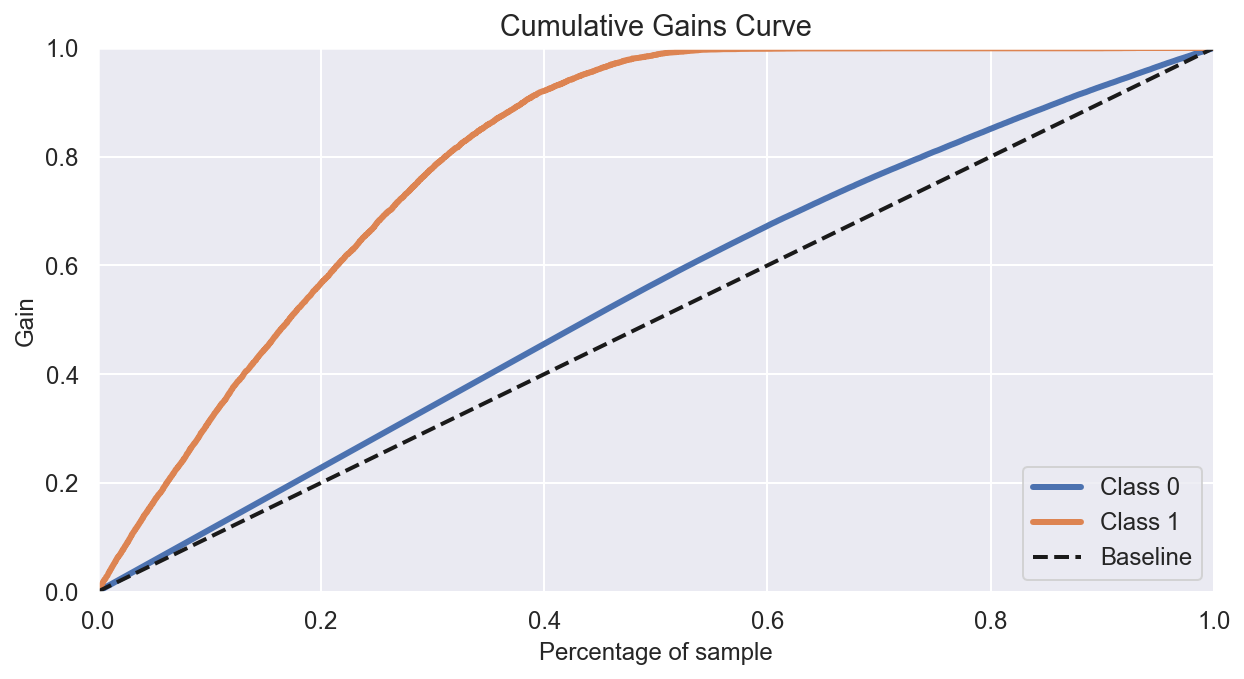

In [88]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb );

### Stratified Cross Validation

In [89]:
model_xgb_cv = cross_validation( 'XGBoost', model_xgb, x_train, y_train )
model_xgb_cv

,Precision_at_k,Recall_at_k
XGBoost,0.31 +/- 0.0,0.83 +/- 0.0


## 7.5. LightGBM

In [90]:
# model
model_lgb = lgb.LGBMClassifier(objective='binary', class_weight='balanced')

# training
model_lgb.fit( x_train, y_train )

# prediction
yhat_lgb = model_lgb.predict_proba( x_val )

### Precision and Recall at K metrics

In [91]:
model_lgb_metrics = at_k_metrics( 'LightGBM', x_validation, y_validation, yhat_lgb )
model_lgb_metrics

,Precision_at_k,Recall_at_k
LightGBM,0.332,0.712


### Cumulative Gains and Lift curves

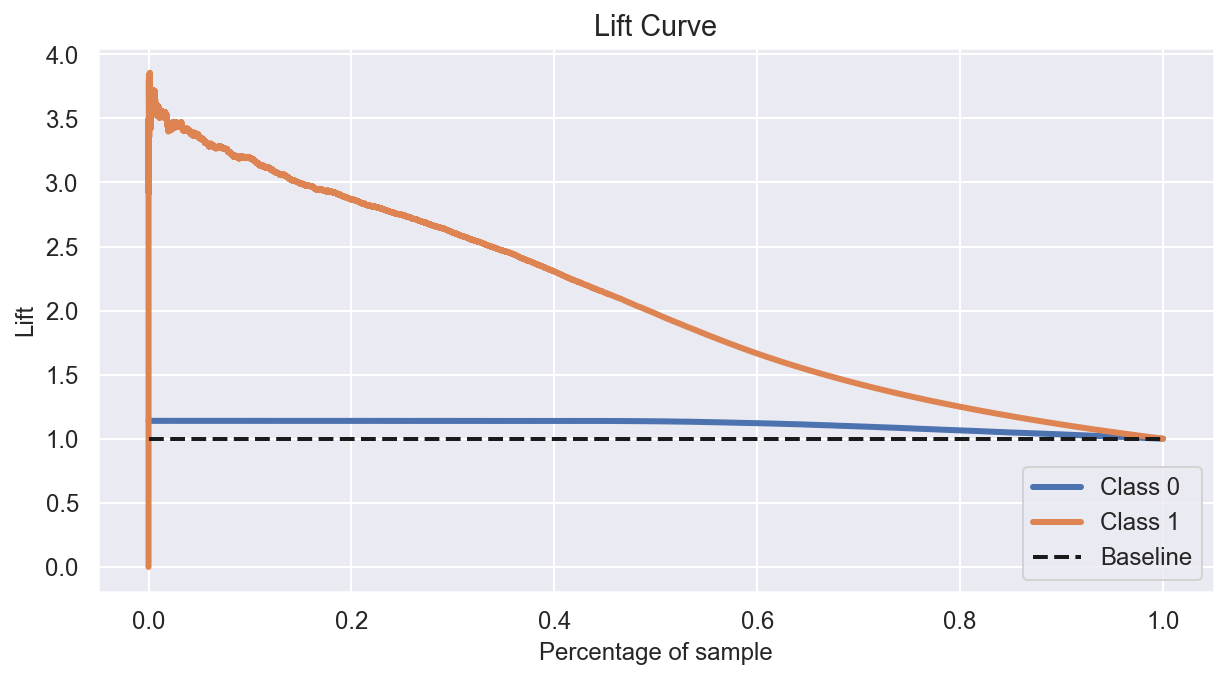

In [92]:
skplt.metrics.plot_lift_curve( y_val, yhat_lgb );

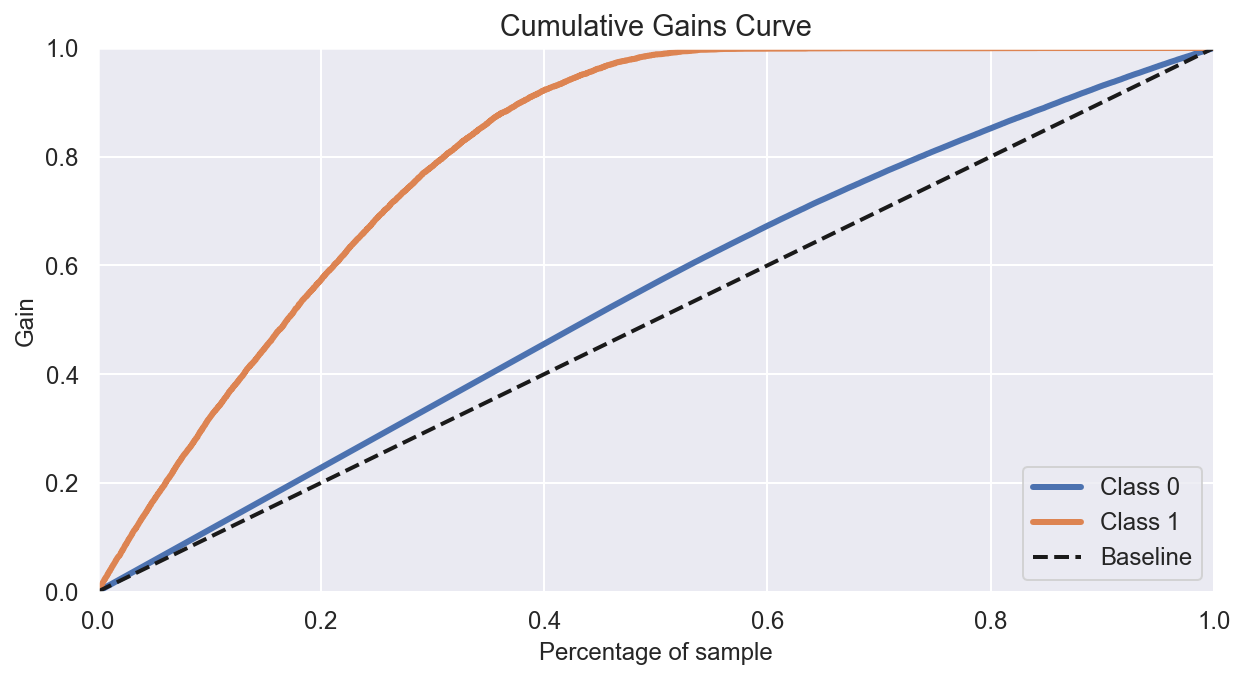

In [93]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_lgb );

### Stratified Cross Validation

In [94]:
model_lgb_cv = cross_validation( 'LightGBM', model_lgb, x_train, y_train )
model_lgb_cv

,Precision_at_k,Recall_at_k
LightGBM,0.31 +/- 0.0,0.83 +/- 0.0


# 8.0. MODELS PERFORMANCE

## 8.1. Precision and Recall At K metrics performance

In [95]:
all_metrics = pd.concat( [knn_metrics, lr_metrics, et_metrics, model_xgb_metrics, model_lgb_metrics] )
all_metrics

,Precision_at_k,Recall_at_k
KNN,0.298,0.638
Logistic Regression,0.285,0.611
Extra Trees,0.3,0.643
XGBoost,0.328,0.702
LightGBM,0.332,0.712


## 8.2. Cross Validation performance

In [96]:
all_cv = pd.concat( [ knn_cv, lr_cv, et_cv, model_xgb_cv, model_lgb_cv ] )
all_cv

,Precision_at_k,Recall_at_k
KNN,0.28 +/- 0.0,0.76 +/- 0.0
Logistic Regression,0.28 +/- 0.0,0.74 +/- 0.0
Extra Trees,0.29 +/- 0.0,0.77 +/- 0.0
XGBoost,0.31 +/- 0.0,0.83 +/- 0.0
LightGBM,0.31 +/- 0.0,0.83 +/- 0.0


# 9.0. HYPERPARAMETER FINE-TUNING

We'll continue our solution with XGBoost due the great results.

## 9.1. Random Search

In [97]:
# params = { 'learning_rate' : [ 0.1, 0.08, 0.05, 0.03, 0.01 ],
#            'n_estimators' : [ 100, 300, 500, 700, 1000 ],
#            'max_depth' : [ 3, 5, 8, 9, 11 ],
#            'subsample' : [ 0.8, 0.9, 1 ],
#            'colsample_bytree' : [ 0.7, 0.8, 0.9, 1 ],
#            'gamma' : [ 0, 1, 5 ] 
#          }

# max_eval = 5

In [98]:
# results = pd.DataFrame()

# for i in range( max_eval ):
#     # choose random values for model
#     hp = { k: random.sample( v, 1)[0] for k, v in params.items() }
#     print( hp )
    
#     # model
#     model_xgb = xgb.XGBClassifier( objective = 'binary:logistic',
#                                    learning_rate = hp['learning_rate'],
#                                    n_estimators = hp['n_estimators'],
#                                    max_depth = hp['max_depth'],
#                                    subsample = hp['subsample'],
#                                    colsample_bytree = hp['colsample_bytree'],
#                                    gamma = hp['gamma'] )

#     # training
#     model_xgb.fit( x_train, y_train )

#     # prediction
#     yhat_xgb = model_xgb.predict_proba( x_val )

#     # cross validation
#     model_xgb_cv = cross_validation( 'XGBoost', model_xgb, x_train, y_train )
#     results = pd.concat([results, model_xgb_cv])

# results

**Did not obtained the expected results with the hyperparameter fine-tuning, so i decided to continue with low n_estimators to reduce the model size.**

## 9.2. Final Model

In [99]:
params_tuned = { 'learning_rate' : 0.03,
                 'n_estimators' : 100,
                 'max_depth' : 8,
                 'subsample' : 0.8,
                 'colsample_bytree' :0.9,
                 'gamma' : 0 
               }

In [100]:
# model
model_xgb_tuned = xgb.XGBClassifier( objective = 'binary:logistic',
                               learning_rate = params_tuned['learning_rate'],
                               n_estimators = params_tuned['n_estimators'],
                               max_depth = params_tuned['max_depth'],
                               subsample = params_tuned['subsample'],
                               colsample_bytree = params_tuned['colsample_bytree'],
                               gamma = params_tuned['gamma'] )

# training
model_xgb_tuned.fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict_proba( x_val )

# metrics
model_xgb_tuned_metrics = at_k_metrics( 'XGBoost', x_validation, y_validation, yhat_xgb_tuned )
model_xgb_tuned_metrics

,Precision_at_k,Recall_at_k
XGBoost,0.332,0.711


In [101]:
# cross validation
model_xgb_tuned_cv = cross_validation( 'XGBoost', model_xgb_tuned, x_train, y_train )
model_xgb_tuned_cv

,Precision_at_k,Recall_at_k
XGBoost,0.31 +/- 0.0,0.83 +/- 0.0


In [102]:
# saving model
pickle.dump( model_xgb_tuned, open( '/Users/mathe/Repos_ComunidadeDS/health_insurance_cross_sell/src/models/health_insurance_model.pkl', 'wb' ) )

# 10.0. FINAL METRICS UNDERSTANDING

In [103]:
print( f'Precision at K: { model_xgb_tuned_metrics.iloc[ 0, 0 ] }' )

Precision at K: 0.332


**Meaning**: Dentro dos 20.000 primeiros clientes ordenados de acordo com a propensão de compra, 31% deles ( 6.000 ), estão realmente interessados.

In [104]:
print( f'Recall at K: { model_xgb_tuned_metrics.iloc[ 0, 1 ] }' )

Recall at K: 0.711


**Meaning**: Dentro dos 20.000 primeiros clientes ordenados de acordo com a propensão de compra, estão 83% do total de interessados.

Lift curve:

**Business gains**:

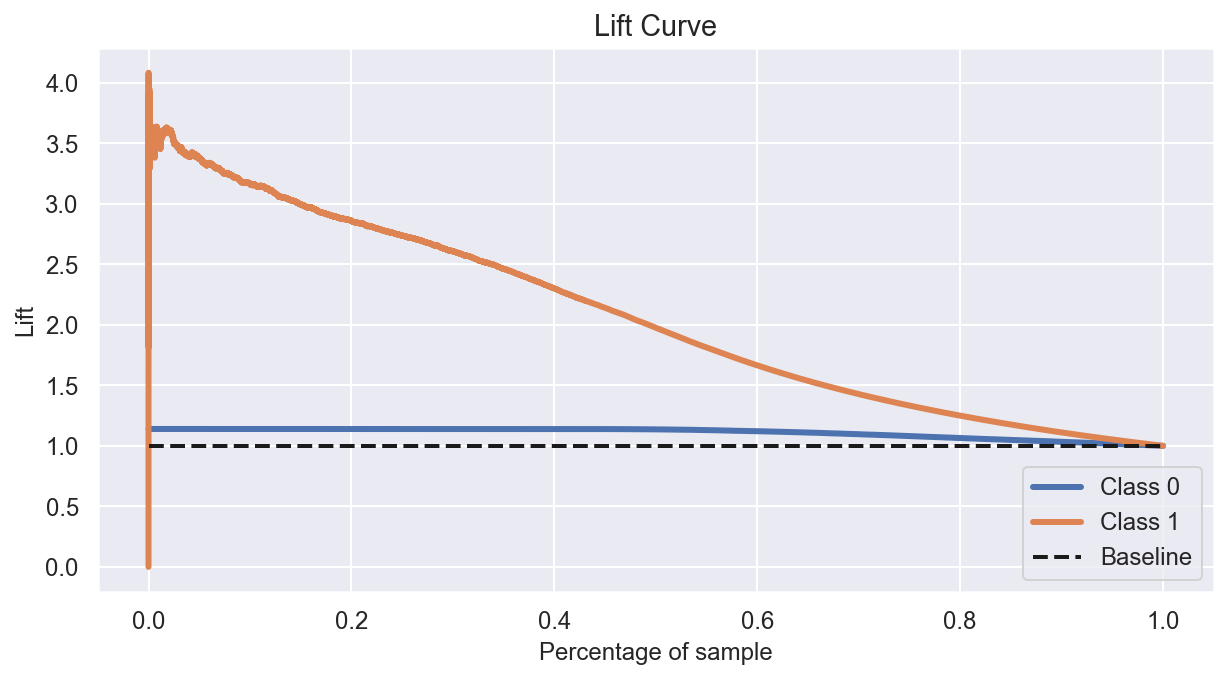

In [105]:
skplt.metrics.plot_lift_curve( y_val, yhat_xgb_tuned );

Botar dataframe com ganhos aqui, tipo baseline=x / meu modelo = x/2

# 11.0. DEPLOY

## 11.1. Health Insurance Class

In [106]:
class HealthInsurance:
    def __init__ (self):
        self.homepath              = ( '/Users/mathe/Repos_ComunidadeDS/health_insurance_cross_sell/' )
        self.age_scaler            = pickle.load( open( self.home_path + 'src/feature_preparation/age_scaler.pkl' ) )
        self.annual_scaler         = pickle.load( open( self.home_path + 'src/feature_preparation/annual_scaler.pkl' ) )
        self.gender_encoding       = pickle.load( open( self.home_path + 'src/feature_preparation/gender_encoding.pkl' ) )
        self.policy_sales_encoding = pickle.load( open( self.home_path + 'src/feature_preparation/policy_sales_encoding.pkl' ) )
        self.region_code_encoding  = pickle.load( open( self.home_path + 'src/feature_preparation/region_code_encoding.pkl' ) )
        self.vintage_scaler        = pickle.load( open( self.home_path + 'src/feature_preparation/vintage_scaler.pkl' ) )
        
        #self.xgboost_model         = 
        
    def feature_engineering( df2 ):

        # 2.0. FEATURE ENGINEERING

        df2 = df1.copy()

        # vehicle age
        df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'below_1_year' if x == '< 1 Year' else 
                                                                 'between_1_2_years' if x == '1-2 Year' else 'over_2_years' )

        # vehicle damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )
        
        return df2
        
    def data_preparation( df5 ):

        ## 5.1. Normalization

        # annual premium - normal curve
        
        df5['annual_premium'] = self.annual_scaler.transform( df5[['annual_premium']].values )
        
        ## 5.2. Rescaling

        # age
        df5['age'] = self.age_scaler.transform( df5[['age']].values )
        
        # vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )
    
        ## 5.3. Encoding

        # region code - Target Encoding

        df5['region_code'] = df5['region_code'].map( self.region_code_encoding )
    
        # policy sales channel - Frequency Encoding

        df5['policy_sales_channel'] = df5['policy_sales_channel'].map( self.policy_sales_encoding )
       
        # gender

        df5['gender'] = self.gender_encoding.transform( df5['gender'] )

        # vehicle age - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )
        
        # COLS SELECTED
        selected_cols = [ 'vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage',
                          'policy_sales_channel', 'previously_insured' ]
        
        return df5[ selected_cols ]
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )

        # join prediction into original data
        original_data['score'] = pred
        
        return original_data.to_json( orient='records', data_format='iso' )

## 11.2. API Handler

In [107]:
# # loading model
# homepath = ( '/Users/mathe/Repos_ComunidadeDS/health_insurance_cross_sell/' )
# model    = pickle.load( open( homepath + 'src/models/health_insurance_model.pkl' ) )

# # initialize API
# app = Flask( __name__ )

# @app.route( '/predict', methods=['POST'] )
# def health_insurance_predict():
#     test_json = request.get_json()
    
#     if test_json: # there is data
#         if isinstance( test_json, dict ):# unique example
#             test_raw = pd.DataFrame( test_json, index=[0] )
            
#         else: # multiple example
#             test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
#         # instantiate health insurance class
#         pipeline = HealthInsurance()
        
#         # feature engineering
#         df2 = pipeline.feature_engineering( test_raw )
        
#         # data preparation
#         df5 = pipeline.data_preparation( df2 )
        
#         # prediction
#         df_response = pipeline.get_prediction( model, test_raw, df5 )
        
#         return df_response
    
#     else:
#         return Response( '{}', status=200, mimetype='application/json' )
    
# if __name__ == '__main__':
#     app.run( '0.0.0.0', debug=True )

## 11.3. API Tester

In [108]:
df_test = df_test.copy()

# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [109]:
# API call
url = 'https://health-insurance-ranker.herokuapp.com/predict'
header = { 'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code: {}'.format( r.status_code ) )

Status Code: 200


In [110]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,score
73935,455045,0,0.200,1,0.122,0,between_1_2_years,1,-0.284,0.194,0.017,0.481
72211,453321,0,0.215,1,0.125,0,between_1_2_years,1,-0.248,0.194,0.014,0.480
113441,494551,0,0.200,1,0.127,0,below_1_year,1,-0.367,0.194,0.014,0.478
86753,467863,0,0.215,1,0.112,0,between_1_2_years,1,-0.269,0.209,0.668,0.476
87575,468685,1,0.215,1,0.122,0,between_1_2_years,1,-0.550,0.209,0.014,0.476
